In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import numpy as np
import scipy as sp
import scipy.stats
import pickle
import os.path
import sys

import theano
import theano.tensor as T
# from theano.compile.nanguardmode import NanGuardMode
# from lasagne.updates import adam

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from matplotlib.ticker import FormatStrFormatter
from IPython import display

size = matplotlib.rcParams['figure.figsize']
matplotlib.rcParams['figure.figsize'] = [size[0] * 1.5, size[1]* 1.5]

In [2]:
### utilities

def sample_categorical(pi, axis = -1, keepdims = False):
    pi_cumsum = pi.cumsum(axis = axis)
    samples = np.apply_along_axis( \
        lambda a: a.searchsorted(np.random.uniform(0, 1)), \
        arr = pi_cumsum, \
        axis = axis, \
    )
    if keepdims:
        return np.expand_dims(samples, axis = axis)
    else:
        return samples
    

def one_hot_last_axis(values, C):
    return (np.arange(C) == np.expand_dims(values, axis = -1)).astype(int)

def normalize_exp(x, axis = None, keepdims = False):
    xm = x.max(axis = axis, keepdims = True)
    exp_x = np.exp(x - xm)
    return exp_x / exp_x.sum(axis = axis, keepdims = True)

def T_logsumexp(x, axis = None, keepdims = False):
    xm = x.max(axis = axis, keepdims = True)
    return T.log(T.exp(x - xm).sum(axis = axis, keepdims = keepdims)) + xm

def init_T_weight(n_in, n_out, name, is_sigmoid = False, is_zero = False):
    if is_zero:
        value = np.zeros((n_in, n_out), dtype = theano.config.floatX)
    else:
        value = np.asarray(
            np.random.uniform(
                low = -np.sqrt(6. / (n_in + n_out)),
                high = np.sqrt(6. / (n_in + n_out)),
                size = (n_in, n_out)
            ),
            dtype = theano.config.floatX
        )
    if is_sigmoid:
        value *= 4
    w = theano.shared(value = value, name = name + '_w', borrow = True)
    b = theano.shared(
        value = np.zeros((n_out,), dtype = theano.config.floatX),
        name = name + '_b',
        borrow = True,
    )
    return w, b

In [31]:
### PLOT ###

COLOR_CYCLE = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']

class LinePlotter:
    def __init__(self, title, yscale = 'log', ax = None, grid = False):
        self.data = []
        self.lines = []
        self.is_actives = []
        self.update_intervals = []
        self.title = title
        self.yscale = yscale
        self.ax = plt.gca() if ax is None else ax
        self.ax.set_title(self.title)
        self.ax.set_yscale(self.yscale)
        if 'log' in self.yscale:
            self.ax.get_yaxis().get_major_formatter().labelOnlyBase = False
        if grid:
            self.ax.grid()
            
    # returns a line index for update/finish calls
    def add_line(self, label, data = None, update_interval = 50):
        idx = len(self.data)
        if data is None:
            data = [], []
        self.data.append(data)
        line, = self.ax.plot(*self.data[-1])
        self.lines.append(line)
        line.set_label(label)
        self.update_intervals.append(update_interval)
        self.is_actives.append(True)
        self.ax.legend()
        self.draw(idx)
        return idx
            
    def get_label_data(self, idx):
        return self.lines[idx].get_label(), self.data[idx]

    def draw(self, idx):
        assert self.is_actives[idx]
        self.lines[idx].set_xdata(self.data[idx][0])
        self.lines[idx].set_ydata(self.data[idx][1])
        self.ax.relim()
        self.ax.autoscale_view()
        display.clear_output(wait = True)
        display.display(plt.gcf())

    def update(self, idx, x, y, force = False):
        self.data[idx][0].append(x)
        self.data[idx][1].append(y)
        if force or len(self.data[idx][0]) % self.update_intervals[idx] == 0:
            self.draw(idx)

    def finish(self, idx):
        if self.is_actives[idx]:
            self.draw(idx)
            self.is_actives[idx] = False
    
    def finish_all(self, plt_close = True):
        for idx in range(len(self.data)):
            self.finish(idx)
        plt.ioff()
        if plt_close:
            plt.close()

def contour_distns(distns, margin = 2, delta = 100j, colors = COLOR_CYCLE, ax = None, **countour_args):
    ax = plt.gca() if ax is None else ax
    xmin, xmax, ymin, ymax = ax.axis()
    X, Y = np.mgrid[
        xmin - margin : xmax + margin : delta, 
        ymin - margin : ymax + margin : delta,
    ]
    a = distns[0][0]
    mus_mu_distns = distns[1][0]
    mus_sigma2_distns = distns[2][0]
    mus_valid_distns = distns[3][0]
    mus_p = [0 for _ in range(prop_mdn.block_prop_C)]
    for nn_c in range(prop_mdn.C):
        for c in range(prop_mdn.block_prop_C):
            mu_mu = mus_mu_distns[nn_c, c]
            mu_sigma = np.sqrt(mus_sigma2_distns[nn_c, c])
            mus_p[c] += a[nn_c] * mus_valid_distns[nn_c, c] * mlab.bivariate_normal(X, Y, mu_sigma, mu_sigma, *mu_mu)
    mus_valid_distns_all = mus_valid_distns.mean(axis = 0)
    for c in range(prop_mdn.block_prop_C):
        mu_contour = ax.contour(X, Y, mus_p[c], 6, colors = colors[c % len(colors)], alpha = mus_valid_distns_all[c], **countour_args)
        ax.clabel(mu_contour, fontsize = 9, inline = 1)

def scatter_xs(xs, zs = None, color = 'black', ax = None, **scatter_args):
    assert zs is None or zs.size == xs.size / 2
    ax = plt.gca() if ax is None else ax
    n = int(xs.size / 2)
    if len(xs.shape) != 2:
        xs = xs.reshape((n, 2))
    if zs is None:
        ax.scatter(xs[:, 0], xs[:, 1], color = color, **scatter_args)
    else:
        zs = zs.reshape(n)
        C = zs.max().astype(int) + 1
        for c in range(C):
            xcs = xs[zs == c]
            ax.scatter(xcs[:, 0], xcs[:, 1], color = COLOR_CYCLE[c % len(COLOR_CYCLE)], edgecolor = 'black', linewidth = '1', **scatter_args)
    ax.axis('equal')
            

In [231]:
# DP 2d gmm w/ random isotropic cluster variance and cluster means.
# infer Pr[cluster means | samples]

### HYPER PARAMETERS ###

# alpha    DP param
# a_0      cluster NIG param
# b_0      cluster NIG param
# mu_0     cluster NIG param
# sigma_0  cluster NIG param
# n        number of points

class Params:
    def __init__(self, alpha, a_0, b_0, mu_0, lambda_0, n):
        self.alpha = alpha
        self.a_0 = a_0
        self.b_0 = b_0
        self._invgamma = sp.stats.invgamma(a_0, scale = b_0)
        self.mu_0 = mu_0
        self.lambda_0 = lambda_0
        self.n = n
        
    def __repr__(self):
        return "{}({})".format(self.__class__.__name__, self.__str__())
        
    def __str__(self):
        return "alpha = {}, Normal-InvGamma({}, {}, {}, {}), n = {}".format(
            self.alpha, 
            self.mu_0,
            self.lambda_0,
            self.a_0,
            self.b_0,
            self.n,
        )
    
    def __eq__(self, other):
        return repr(self) == repr(other)
    
    def sample_nig(self, k = 1):
        sigma2 = self._invgamma.rvs(k)
        mu = np.random.randn(k, 2) * np.sqrt(sigma2[:, None] / self.lambda_0) + self.mu_0
        return mu, sigma2
    
    # ignore constant term
    def logpdf_nig(self, mu, sigma2):
        l = self._invgamma.logpdf(sigma2)
        mu_sigma2 = sigma2 / self.lambda_0
        l += -np.square(mu - self.mu_0).sum(axis = 1) / (2 * mu_sigma2) - np.log(mu_sigma2)
        return l[:, None]
    
default_params = Params(1.2, 2, 0.1, np.zeros(2), 0.1, 100)

### SAMPLE ###

def xs_1d_pca(xss):
    offsets_3d = xss.mean(axis = 1, keepdims = True)  # (k, 1, 2)
    zero_mean_xss = xss - offsets_3d
    Ts = []
    Ws = []
    for i in range(xss.shape[0]):
        U, s, V = np.linalg.svd(zero_mean_xss[i], full_matrices = False)
        T, W = U[:, 0] * s[0], V[0]
        if W[0] <= 0:
            T, W = -T, -W
        Ws.append(W)
        Ts.append(T)
    return np.stack(Ts), np.stack(Ws), offsets_3d

# if mus_valid_bits or zs is None, they won't be changed
def sort_cs_pca(muss, sigmass, zss, Ws, offsets_3d, get_argsort = False):
    k = Ws.shape[0]
    muss_1d_argsort = []
    for i in range(k):
        mus_1d = ((muss[i] - offsets_3d[i]) * Ws[i]).sum(axis = 1) # transform mus to 1d
        mus_1d_argsort = mus_1d.argsort()
        muss_1d_argsort.append(mus_1d_argsort)
        muss[i] = muss[i][mus_1d_argsort]
        sigmass[i] = sigmass[i][mus_1d_argsort]
        if zss is not None:
            zss[i] = mus_1d_argsort.argsort()[zss[i]]
    if not get_argsort:
        return muss, sigmass, zss
    else:
        return muss, sigmass, zss, muss_1d_argsort

def sort_xs_pca(zss, xss, Ts):
    k = xss.shape[0]
    vertical_k_idxs = np.arange(k)[:, None]
    Ts_argsort = Ts.argsort() # xs order by first principle component
    xss = xss[vertical_k_idxs, Ts_argsort]
    if zss is not None:
        zss = zss[vertical_k_idxs, Ts_argsort]
    return zss, xss

# Essentially (observation, hidden) pair
def sample(k = 1, sort_pca = False, params = default_params):
    muss = []
    sigmass = []
    zss = []
    xss = []
    for _ in range(k):
        c_mus = []
        c_sigmas = []
        zs = np.zeros(params.n, dtype = int)
        xs = np.zeros((params.n, 2))
        counts = [params.alpha]   # idx 0 means new cluster
        for n in range(params.n):
            z = sample_categorical(np.array(counts) / (n + params.alpha))
            if z == 0:
                zs[n] = len(c_mus)
                m, s = params.sample_nig()
                c_mus.append(m[0])
                c_sigmas.append(s[0])
                counts.append(0)
            else:
                zs[n] = z - 1
            z = zs[n]
            counts[z + 1] += 1
            xs[n] = np.random.randn(2) * c_sigmas[z] + c_mus[z]
        muss.append(np.array(c_mus))
        sigmass.append(np.array(c_sigmas))
        zss.append(zs)
        xss.append(xs)
    zss = np.array(zss)
    xss = np.array(xss)
    if sort_pca:
        Ts, Ws, offsets_3d = xs_1d_pca(xss)
        muss, sigmass, zss = sort_cs_pca(muss, sigmass, zss, Ws, offsets_3d)
        zss, xss = sort_xs_pca(zss, xss, Ts)
        return muss, sigmass, zss, xss, Ws, offsets_3d.squeeze(axis = 1)
    return muss, sigmass, zss, xss

# un-(pca)-sort for gibbs
def permute_valid_mus_front(Cs, mus, mus_valid_bits, zs, xs):
    k = Cs.shape[0]
    unorder = (-mus_valid_bits).argsort(axis = 1)
    unorder_mus = mus[np.arange(k)[:, None], unorder]
    unorder_mus_valid_bits = mus_valid_bits[np.arange(k)[:, None], unorder]
    unorder_zs = unorder.argsort(axis = 1)[np.arange(k)[:, None], zs]
    return Cs, unorder_mus, unorder_mus_valid_bits, unorder_zs, xs

# input assumed valid
# ignore constant terms:
#     P[C]
# thus cannot compare if params are different
def get_log_likelihood(Cs, mus, mus_valid_bits, zs, xs, params = default_params):
    k = xs.shape[0]
    l = np.zeros((k, 1))
    # mus
    l += (np.atleast_2d(mu_rv.logpdf(mus)) * mus_valid_bits).sum(axis = 1, keepdims = True)
    # zs
    l -= np.log(Cs) * params.n
    # xs
    l -= np.square(xs - mus[np.arange(k)[:, None], zs]).sum(axis = 2).sum(axis = 1, keepdims = True) / (2 * sigma2)
    # validity
    l[Cs < 1] = -np.inf
    l[Cs > params.C_max] = -np.inf
    l[Cs != mus_valid_bits.sum(axis = 1, keepdims = True)] = -np.inf
    l[np.any(mus_valid_bits[np.arange(k)[:, None], zs] == 0, axis = 1, keepdims = True)] = -np.inf
    return l

# input assumed valid
# ignore constant terms:
#     P[C]
# thus cannot compare if params are different
def get_log_likelihood_no_zs(Cs, mus, mus_valid_bits, xs, params = default_params):
    k = xs.shape[0]
    l = np.zeros((k, 1))
    # mus (k, C_max, 2)
    l += (np.atleast_2d(mu_rv.logpdf(mus)) * mus_valid_bits).sum(axis = 1, keepdims = True)
    # xs (k, n, 2)
    xs_ls = -np.square(xs[:, :, None, :] - mus[:, None, :, :]).sum(axis = 3) / (2 * sigma2)   # (k, n, C_max)
    mus_valid_bits, _ = np.broadcast_arrays(np.invert(mus_valid_bits.astype(bool))[:, None, :], xs_ls)
    xs_ls[mus_valid_bits] = -np.inf     # set invalid mus with prob 0
    l += sp.misc.logsumexp(xs_ls, axis = 2).sum(axis = 1, keepdims = True) - params.n * np.log(Cs)
    l[Cs < 1] = -np.inf
    l[Cs > params.C_max] = -np.inf
    l[Cs != mus_valid_bits.sum(axis = 1, keepdims = True)] = -np.inf
    return l

([array([[-0.36898205, -1.54451469],
         [-1.315369  , -0.31858154],
         [ 0.10854168, -1.04618889],
         [-0.45026942,  0.37491217],
         [ 1.91758998,  0.08290813],
         [ 1.00423348,  1.8384808 ],
         [ 0.9590023 ,  2.35726836]])],
 [array([ 0.12751445,  0.05529558,  0.09831409,  0.1173474 ,  0.07126201,
          0.11699338,  0.11385603])],
 array([[0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3,
         3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
         3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
         3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
         3, 4, 4, 5, 5, 5, 5, 5, 5, 5, 6, 5]]))

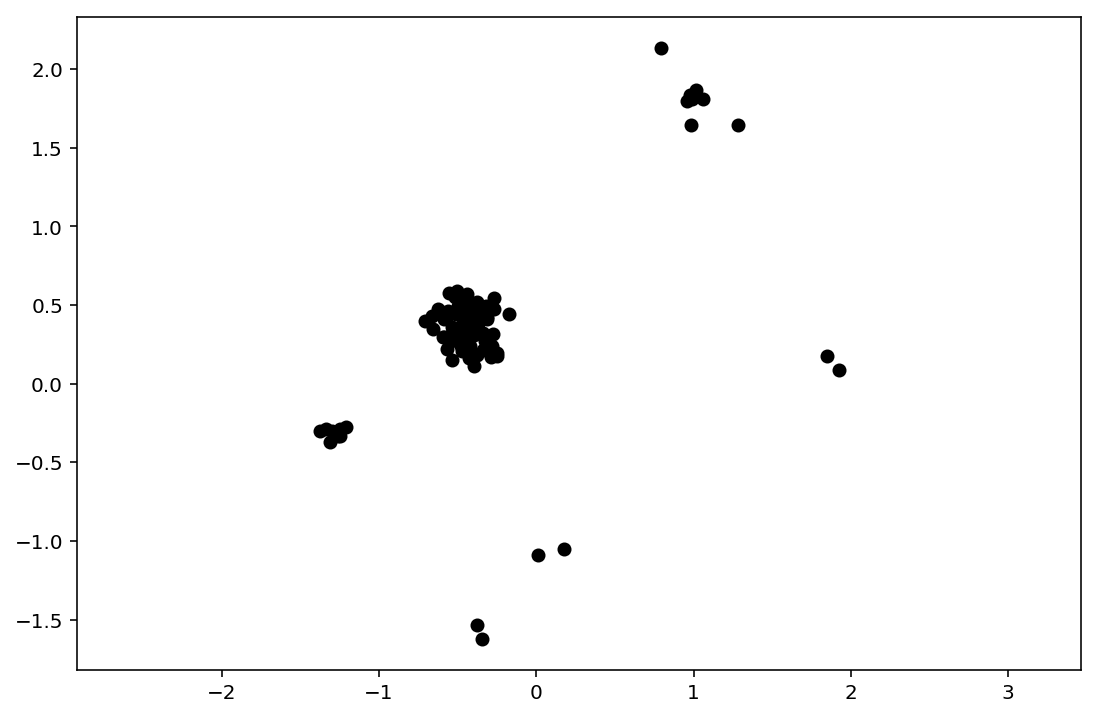

In [234]:
muss, sigmass, zss, xss, _, _ = sample(1, True)
scatter_xs(xss)
muss, sigmass, zss

In [226]:
# Test get_log_likelihood_* fns. Use with n small.

# from itertools import product

# Cs, mus, mus_valid_bits, zs, xs = sample(1, Cs = 6)

# print(Cs, mus, mus_valid_bits, zs)

# print(get_log_likelihood(Cs, mus, mus_valid_bits, zs, xs)[0, 0])

# C = Cs[0, 0]
# ls = []
# for z_vals in product(range(C), repeat = default_params.n):
#     t_zs = np.array(z_vals, dtype = int)[None, :]
#     ls.append(get_log_likelihood(Cs, mus, mus_valid_bits, t_zs, xs))
# print(sp.misc.logsumexp(ls))

# print(get_log_likelihood_no_zs(Cs, mus, mus_valid_bits, xs)[0, 0])

In [5]:
class MDN:
    # layers contains [(num_cells, act_fn), ...]
    def __init__(self, name, num_in, layers, C, num_out_per_C, num_distns_per_C):
        # last layer's activation should be handled by self.T_out_to_distns
        assert layers[-1] == (C + C * num_out_per_C, None) 
        self.name = name
        self.num_in = num_in
        self.layers = layers
        self.C = C
        self.num_out_per_C = num_out_per_C
        self.num_distns_per_C = num_distns_per_C
        self.init_layers()
        self.init_utility_fns()
        
    def init_layers(self):
        self.layer_weights = []
        num_last = self.num_in
        for i, (num_cells, act_fn) in enumerate(self.layers):  
            w, b = init_T_weight(num_last, num_cells, self.name + '_{}_{}'.format(i, i + 1))
            self.layer_weights.append((w, b))
            num_last = num_cells
        self.layer_weights = tuple(self.layer_weights)
        self.weights = sum(self.layer_weights, ())
        
    def forward(self, T_in):
        T_last = T_in
        for i, ((num_cells, act_fn), (w, b)) in enumerate(zip(self.layers, self.layer_weights)):
            if act_fn is None:
                T_last = T_last.dot(w) + b
            else:               
                T_last = act_fn(T_last.dot(w) + b)
        return self.T_out_to_distns(T_last)
                
    def T_out_to_distns(self, T_out):
        at = 0
        pi_distn = T.nnet.softmax(T_out[:, at : at + self.C])
        at += self.C
        C_distns_coll = [[] for _ in range(self.num_distns_per_C)]
        for _ in range(self.C):
            C_distns = self.T_mixture_out_to_distns(T_out[:, at : at + self.num_out_per_C])
            for coll, distn in zip(C_distns_coll, C_distns):
                coll.append(distn)
            at += self.num_out_per_C
        return [pi_distn] + [T.stack(coll, axis = 1) for coll in C_distns_coll]
    
    def T_mixture_out_to_distns(self, T_mixture_out):
        raise NotImplementedError
    
    def T_log_probs(self, T_distns, *sample_tensors):
        k = sample_tensors[0].shape[0]
        a, mixture_distns = T_distns[0], T_distns[1:]
        cluster_log_probs = []
        for c in range(self.C):
            cluster_log_probs.append(
                T.log(a[:, c])[:, None] + \
                self.T_mixture_log_prob([distn[:, c] for distn in mixture_distns], *sample_tensors)
            )
        return T.concatenate(cluster_log_probs, axis = 1)
    
    def T_mixture_log_prob(self, T_mixture_distns, *sample_tensors):
        raise NotImplementedError
        
    def init_utility_fns(self):
        self.get_weights = theano.function([], self.weights)
        file_layer_weights = [(T.dmatrix(w.name + '_file'), T.dvector(b.name + '_file')) for w, b in self.layer_weights]
        file_weights = sum(file_layer_weights, ())
        self.set_weights = theano.function( \
            file_weights, \
            file_weights, \
            updates = list(zip(self.weights, file_weights)), \
        )
                                           
    def dump_weights(self, suffix):
        file_name = "{}_{}.pkl".format(self.name, suffix)
        if os.path.isfile(file_name):
            print("{} already exists, abort.".format(file_name))
            return
        with open(file_name, 'wb') as f:
            pickle.dump(self.get_weights(), f)
        print('Dumped to file {}'.format(file_name))

    def load_weights(self, suffix):
        file_name = "{}_{}.pkl".format(self.name, suffix)
        with open(file_name, 'rb') as f:
            self.set_weights(*pickle.load(f))
        print('Loaded from file {}'.format(file_name))
        
    

In [6]:
### Block Proposal NN ###

# ALL BASED ON default_params!!!

# Propose block_prop_C clusters given observations, all other clusters, and all
# assignments to other clusters.

# Prop NN
# Parmetrize variable cluster nums as C_max cluster means and a bit map.
# Propose 2 clusters (mean + valid bit) each time
# Input: xs, C_max * (mean, valid bit, proposing bit), Ws, offsets
#        if proposing bit == 1, mean and valid bit = 0
# Output: MDN of 2 * (prop_mean mu, prop_mean sigma2, prop_mean valid bit prob)
class BlockPropMDN(MDN):
    MIN_SIGMA2 = 0.00001
    L1_reg = 0.0001

    def __init__(self):
        self.block_prop_C = 2
        nn_C = 4
        n_in = default_params.C_max * 4 + default_params.n * 2 + 2 + 2
        n_mixture_out = self.block_prop_C * 4
        n_out = nn_C + nn_C * n_mixture_out
        n_mid1 = max(n_in, n_out) * 4
        n_mid2 = max(n_in, n_out) * 4

        n_distns_per_C = 3      # gathered mu, gathered sigma2, gathered valid bit probs

        MDN.__init__(
            self,
            "prop_mdn", 
            n_in,
            [
                (n_mid1, T.nnet.elu),
                (n_mid2, T.nnet.elu),
                (n_out, None),
            ], 
            nn_C, 
            n_mixture_out,
            n_distns_per_C,
        )

        # batch size k

        ## inputs
        self.flat_pxs = T.dmatrix('flat_pxs')                     # (k, n * 2)
        self.flat_input_mus = T.dmatrix('flat_input_mus')         # (k, C_max * 2) prop_mus have 0
        self.input_valid_bits = T.dmatrix('input_valid_bits')     # (k, C_max) prop_mus have 0
        self.input_prop_bits = T.dmatrix('input_prop_bits')       # (k, C_max) prop_mus have 0
        self.Ws = T.dmatrix('Ws')                                 # (k, 2) = pca weights of xs
        self.offsets = T.dmatrix('offsets')                       # (k, 2) = pca offsets of xs

        ## props
        self.prop_valid_bits = T.dmatrix('prop_valid_bits')       # (k, block_prop_C) = processed proposing zs
        self.flat_prop_mus = T.dmatrix('flat_prop_mus')           # (k, block_prop_C * 2) = mus + hids
        
        self.input_tensors = [
            self.flat_pxs, 
            self.flat_input_mus, 
            self.input_valid_bits, 
            self.input_prop_bits,
            self.Ws, 
            self.offsets,
        ]
        self.output_prop_tensors = [
            self.flat_prop_mus,
            self.prop_valid_bits, 
        ]
        self.all_tensors = self.input_tensors + self.output_prop_tensors
        
        
        self.output_prop_tensors_reverse = [
            self.flat_prop_mus[:, ((np.arange(self.block_prop_C) * 2)[::-1, None] + np.arange(2)).flatten()],
            self.prop_valid_bits[:, np.arange(self.block_prop_C)[::-1]], 
        ]
        
        # ``forward''
        T_in = self.T_nn_input(*self.input_tensors)
        T_distns = self.forward(T_in)
        mixture_prop_log_probs = self.T_log_probs(T_distns, *self.output_prop_tensors)
        mixture_prop_log_probs_reverse = self.T_log_probs(T_distns, *self.output_prop_tensors_reverse)
        prop_log_prob = T_logsumexp(
            T.concatenate([mixture_prop_log_probs, mixture_prop_log_probs_reverse], axis = 1),
            axis = 1, 
            keepdims = True,
        )
        
#         # ``backward''
#         T_back_in = self.T_nn_input(*self.input_tensors)
#         distns = self.forward(T_in)
#         mixture_prop_log_probs = self.T_mixture_prop_log_probs(distns, *self.output_prop_tensors)
#         prop_log_prob = T_logsumexp(mixture_prop_log_probs, axis = 1, keepdims = True)

        self.get_distns = theano.function(self.input_tensors, T_distns)
        self.get_prop_log_prob = theano.function(self.all_tensors, prop_log_prob)
        
        # NN training
        self.train_rate = T.dscalar('train_rate')

        # pretrain
        train_target = -prop_log_prob.mean() + self.L1_reg * sum(T.sum(abs(w)) for w, b in self.layer_weights)
        grads = tuple(T.grad(train_target, w) for w in self.weights)
        self.get_train_target = theano.function(self.all_tensors, train_target)
        self.get_train_grads = theano.function(self.all_tensors, grads)
        self.train = theano.function( \
            self.all_tensors + [self.train_rate], \
            [train_target, self.train_rate], \
            # updates = adam(-pretrain_target, x_weights),
            updates = [
                (w, w - self.train_rate * gw) for w, gw in zip(self.weights, grads)
            ],
            # mode = NanGuardMode(nan_is_error=True, inf_is_error=True, big_is_error=True)
        )
    
    def T_nn_input(self, *input_2d_tensors):
        return T.concatenate(input_2d_tensors, axis = 1)
    
    def T_mixture_out_to_distns(self, T_mixture_out):
        mus_mu_distns = []
        mus_sigma2_distns = []
        mus_valid_distns = []
        at = 0
        for _ in range(self.block_prop_C):
            mus_mu_distns.append(T_mixture_out[:, at : at + 2])
            at += 2
            mus_sigma2_distns.append(T.nnet.elu(T_mixture_out[:, at : at + 1]) + 1 + self.MIN_SIGMA2)
            at += 1
            mus_valid_distns.append(T.nnet.sigmoid(T_mixture_out[:, at : at + 1]))
            at += 1
        return T.stack(mus_mu_distns, axis = 1), \
            T.concatenate(mus_sigma2_distns, axis = 1), \
            T.concatenate(mus_valid_distns, axis = 1)
    
    def T_mixture_log_prob(self, T_mixture_distns, *sample_tensors):
        flat_prop_mus, prop_valid_bits = sample_tensors
        k = prop_valid_bits.shape[0]
        prop_mus = flat_prop_mus.reshape((k, self.block_prop_C, 2))
        # mus_mu_distns_c           (k, block_prop_C, 2)
        # mus_sigma2_distns_c       (k, block_prop_C)
        # mus_valid_bits_distns_c   (k, block_prop_C)
        mus_mu_distns_c, mus_sigma2_distns_c, mus_valid_bits_distns_c = T_mixture_distns
        # mu
        l_mu = (
            -T.sqr(prop_mus - mus_mu_distns_c).sum(axis = 2) / (2 * mus_sigma2_distns_c) - T.log(mus_sigma2_distns_c)
        ).sum(axis = 1, keepdims = True) # np.log(2 * np.pi) term ignored
        l = (T.log(mus_valid_bits_distns_c) + l_mu) * prop_valid_bits \
            + T.log(1 - mus_valid_bits_distns_c) * (1 - prop_valid_bits)
        return l
    
prop_mdn = BlockPropMDN()

# back_input_tensors = [flat_pxs, input_pzs, flat_prop_mus]
# back_output_prop_tensors = [flat_input_mus]

# ``backward'' using flat_prop_mus as part of input
# for backward proposal probability calculation in MH
# T_in_back = prop_mdn.T_nn_input(*back_input_tensors)
# mus_distns_back = prop_mdn.forward(T_in_back)
# mus_cluster_prop_log_probs_back = prop_mdn.T_mus_cluster_prop_log_probs(mus_distns_back, *input_prop_tensors)
# mus_prop_log_prob_back = T_logsumexp(mus_cluster_prop_log_probs_back, axis = 1, keepdims = True)

In [7]:
### Training Functions ###

# ALL BASED ON default_params!!!

# Cs and zs are actually unused, safe to put anything here
def sample_to_train_data(Cs, mus, mus_valid_bits, zs, xs, Ws, offsets, prop_mu_start_idxs = None):
    k = xs.shape[0]
    if prop_mu_start_idxs is None:
        prop_mu_start_idxs = np.random.choice(default_params.C_max - 1, size = (k, 1))  # (k, 1)
    else: 
        assert prop_mu_start_idxs.max() < default_params.C_max - 1 and prop_mu_start_idxs.shape == (k, 1) 
    prop_mu_idxs = np.hstack([prop_mu_start_idxs, prop_mu_start_idxs + 1])              # (k, 2)
    prop_mus_mask = np.zeros((k, default_params.C_max), dtype = bool)              
    prop_mus_mask[np.arange(k)[:, None], prop_mu_idxs] = True                           # (k, C_max)
    
    # inputs are:
    #  [flat_pxs, flat_input_mus, input_valid_bits, input_prop_bits, Ws, offsets]
    
    # flat_pxs: flatten
    flat_pxs = xs.reshape((k, default_params.n * 2))
    
    # flat_input_mus: flatten, mask prop mus to 0 
    input_mus = mus.copy()
    input_mus[np.arange(k)[:, None], prop_mu_idxs] = 0
    flat_input_mus = input_mus.reshape((k, default_params.C_max * 2))
    
    # input_valid_bits
    input_valid_bits = mus_valid_bits.copy()
    input_valid_bits[np.arange(k)[:, None], prop_mu_idxs] = 0
    
    # input_prop_bits
    input_prop_bits = prop_mus_mask.astype(int)
    
    # Ws
      # Ws = Ws
    
    # offsets
    offsets = offsets.reshape((k, 2))
    
    # output props are:
    #   [flat_prop_mus, prop_valid_bits]
    
    # flat_prop_mus: flatten
    flat_prop_mus = mus[np.arange(k)[:, None], prop_mu_idxs].reshape((k, prop_mdn.block_prop_C * 2))
    
    # prop_valid_bits
    prop_valid_bits = mus_valid_bits[np.arange(k)[:, None], prop_mu_idxs]
    
    input_data = [flat_pxs, flat_input_mus, input_valid_bits, input_prop_bits, Ws, offsets]
    output_prop_data = [flat_prop_mus, prop_valid_bits]
    return input_data, output_prop_data

def pretrain_prop_true(batch_size, T = 5000, training_rate_fn = lambda t: 1 / (200 + t / 3), 
                       test_batch = 50, test_interval = 100,
                       plot = True, plotter_data = None, get_plotter_data = True):
    def test(t):
        samples = sample(test_batch, sort_pca = True)
        input_data, output_prop_data = sample_to_train_data(*samples)
        target = prop_mdn.get_train_target(*input_data, *output_prop_data)
        if plot:
            if t > 0 or plot_t_offset == 0:
                plotter.update(plotter_idx, t + plot_t_offset, target)
        else:
            print("iteration", t, target)
    if plot:
        plotter = LinePlotter("Training Curve", "linear")
        if plotter_data is None:
            plotter_idx = plotter.add_line("Loss", update_interval = 1)
            plot_t_offset = 0
        else:
            plotter_idx = plotter.add_line(*plotter_data, update_interval = 1)
            plot_t_offset = plotter_data[1][0][-1] + 1         # 1 more than previous last x value
    for t in range(T):
        if t % test_interval == 0:
            test(t)
        samples = sample(batch_size, sort_pca = True)
        input_data, output_prop_data = sample_to_train_data(*samples)
        old_target, _ = prop_mdn.train(*input_data, *output_prop_data, training_rate_fn(t))
    test(T)
    if plot:
        plotter.finish_all()
        if get_plotter_data:
            return plotter.get_label_data(plotter_idx)
        

In [57]:
### Gibbs ###

# Pack valid cluster means at front of mus

# propto (prod_{x in C_a} P[x | mu_a])^{-1}
def ss_choose_log_probs(C, mus, zs, xs, chosen = None):
    sample = chosen is None
    log_probs = np.zeros(C) - np.inf      # in case some cluster has no points
    for c in range(C):
        mu = mus[c]
        # propto prob^{-1}
        log_probs[c] = (np.square(xs[zs == c] - mu).sum(axis = 1) / (2 * sigma2) \
            + np.log(2 * np.pi) + np.log(sigma2)).sum()
    log_probs -= sp.misc.logsumexp(log_probs)
    if sample:
        chosen = sample_categorical(np.exp(log_probs))
    return chosen, log_probs[chosen]

# random
def ds_choose_log_probs(C, mus, zs, xs, chosen = None):
    if chosen is None:
        chosen = np.random.choice(C)
    return chosen, -np.log(C)  

# for each x_i
#   P[x_i in C_a] \propto P[x_i | x_i in C_a given previous assignments in x_{1:i-1} to C_a as observations]
# by conjugate prior, have this as a multivariate Gaussian with
#   mean     = E[mu_a | x in C_a] = (sum x) / ((sigma^2 / sigma_0^2) + n)
#   variace  = sigma^2 / ((sigma^2 / sigma_0^2) + n) + sigma^2
def ss_split_log_probs(xs_merged, from_firsts = None):
    sample = from_firsts is None
    sigma2_over_sigma02 = sigma2 / mu_sigma2
    if sample:
        from_firsts = np.zeros(xs_merged.shape[0], dtype = bool)
    xs_first_sum, xs_first_n = np.zeros(2), 0
    xs_second_sum, xs_second_n = np.zeros(2), 0
    l = 0
    for k, x in enumerate(xs_merged):
        # estimate mus and sigma2s
        est_mu_first = xs_first_sum / (sigma2_over_sigma02 + xs_first_n)
        est_sigma2_first = sigma2 / (sigma2_over_sigma02 + xs_first_n) + sigma2
        est_mu_second = xs_second_sum / (sigma2_over_sigma02 + xs_second_n)
        est_sigma2_second = sigma2 / (sigma2_over_sigma02 + xs_second_n) + sigma2
        est_mus = np.array((est_mu_first, est_mu_second))
        est_sigma2s = np.array((est_sigma2_first, est_sigma2_second))
        # log probs
        log_probs = -np.square(est_mus - x).sum(axis = 1) / (2 * est_sigma2s) - np.log(est_sigma2s)
        log_probs -= sp.misc.logsumexp(log_probs)
        if sample:
            from_firsts[k] = np.random.rand() < np.exp(log_probs[0])
        if from_firsts[k]:
            l += log_probs[0]
            xs_first_sum += x
            xs_first_n += 1
        else:
            l += log_probs[1]
            xs_second_sum += x
            xs_second_n += 1
    return from_firsts, l

# random
def ds_split_log_probs(xs_merged, from_firsts = None):
    if from_firsts is None:
        from_firsts = np.random.rand(xs_merged.shape[0]) > 0.5
    return from_firsts, - xs_merged.shape[0] * np.log(2)  

# first uniform random
# second prop to prod_{x in C_second} P[x | mu_first]
def sm_choose_log_probs(C, mus, zs, xs, pair = None):
    sample = pair is None
    if not sample:
        first, second = pair
    l = - np.log(C)
    if sample:
        first = np.random.choice(C)
    mu_first = mus[first]
    second_log_probs = np.zeros(C)
    second_log_probs[first] = -np.inf
    for c in range(C):
        if c == first:
            continue
        second_log_probs[c] = -(np.square(xs[zs == c] - mu_first).sum(axis = 1) / (2 * sigma2) \
            - np.log(2 * np.pi) - np.log(sigma2)).sum()
    second_log_probs -= sp.misc.logsumexp(second_log_probs)
    if sample:
        second = sample_categorical(np.exp(second_log_probs))
    l += second_log_probs[second]
    return (first, second), l

# random
def dm_choose_log_probs(C, mus, zs, xs, pair = None):
    if pair is None:
        pair = np.random.choice(C, 2, replace = False)
    return pair, -np.log(C) - np.log(C - 1)

dmss = (dm_choose_log_probs, ss_choose_log_probs, ss_split_log_probs)
smds = (sm_choose_log_probs, ds_choose_log_probs, ds_split_log_probs)

def split_merge(C, mus, zs, xs, params, merge_choose, split_choose, split_split):
    if np.random.rand() < 0.5:          # merge
        if C < 2:
            return C, mus, zs, None
        # merge prop
        # merge second into first
        # P[X -> X']
        (first, second), prop_log_prob = merge_choose(C, mus, zs, xs)
        # X'
        merge_filter = np.logical_or(zs == first, zs == second)
        merged = xs[merge_filter]
        from_firsts = zs[merge_filter] == first
        new_C = C - 1
        new_mus = mus.copy() 
        new_zs = zs.copy()
        if first == new_C:     # if first is last, swap it with second, then merge into second
            new_mus[second], new_mus[first] = new_mus[first], new_mus[second]
            first, second = second, first
            new_zs[zs == second] = first
        else:                  # swap second with last, zs[prev second] = first, zs[now last] = second
            new_mus[second], new_mus[new_C] = new_mus[new_C], new_mus[second]  
            new_zs[zs == second] = first
            new_zs[new_zs == new_C] = second
        # split reverse
        prop_back_log_prob = split_choose(new_C, new_mus, new_zs, xs, first)[1] + \
            split_split(merged, from_firsts)[1]
    else:                             # split
        if C == params.C_max:
            return C, mus, zs, None          
        # split prop
        # P[X -> X']
        chosen, choose_log_prob = split_choose(C, mus, zs, xs)
        merge_filter = (zs == chosen)
        from_firsts, split_log_prob = split_split(xs[merge_filter])
        prop_log_prob = choose_log_prob + split_log_prob
        # X'
        second_idxs = np.where(merge_filter)[0][np.invert(from_firsts)]
        new_C = C + 1
        new_mus = mus
        new_zs = zs.copy()
        new_zs[second_idxs] = C # second is at end
        prop_back_log_prob = merge_choose(new_C, new_mus, new_zs, xs)[1]
    return new_C, new_mus, new_zs, (prop_log_prob, prop_back_log_prob)

def sdds_C(C, mus, zs, xs, params):
    assert params.C_max > 1
    methods = dmss if np.random.rand() > 0.5 else smds
    new_C, new_mus, new_zs, prop_log_probs = split_merge(C, mus, zs, xs, params, *methods)
    if prop_log_probs is None:
        return C, mus, zs
    prop_log_prob, prop_back_log_prob = prop_log_probs
    # P[X]
    model_log_prob = get_log_likelihood( 
        np.atleast_2d(C),
        mus[None, :, :], 
        np.atleast_2d([1] * C + [0] * (params.C_max - C)),      # mus_valid_bits
        zs[None, :], 
        xs[None, :, :], 
        params = params,
    )[0, 0]
    # P[X']
    model_prop_log_prob = get_log_likelihood( 
        np.atleast_2d(new_C),
        new_mus[None, :, :], 
        np.atleast_2d([1] * new_C + [0] * (params.C_max - new_C)),      # mus_valid_bits
        new_zs[None, :], 
        xs[None, :, :], 
        params = params,
    )[0, 0]
    log_accept_ratio = model_prop_log_prob + prop_back_log_prob - (model_log_prob + prop_log_prob)
#     print(np.exp(log_accept_ratio))
    if np.random.rand() < np.exp(log_accept_ratio):
        return new_C, new_mus, new_zs
    else:
        return C, mus, zs

# xs are fixed observations
# C   int
# mus (C_max, 2)
# zs  (n,)
# xs  (n, 2)
def gibbs_step(C, mus, zs, xs, params, sdds = True):
    # C
    if sdds:
        for _ in range(np.ceil(params.C_max / 2).astype(int)):
            C, mus, zs = sdds_C(C, mus, zs, xs, params)
        new_C = C
    else:
        probs_with_C = np.zeros(params.C_max) - np.inf
        for new_C in range(1, params.C_max + 1):
            if new_C <= zs.max():
                continue
            probs_with_C[new_C - 1] = get_log_likelihood(
                np.atleast_2d(new_C),
                mus[None, :, :], 
                np.atleast_2d([1] * new_C + [0] * (params.C_max - new_C)),      # mus_valid_bits. valid mus are up front
                zs[None, :], 
                xs[None, :, :],
                params = params,
            )
        probs_with_C -= probs_with_C.max()
        probs_with_C = np.exp(probs_with_C)
        probs_with_C /= probs_with_C.sum()
        new_C = sample_categorical(probs_with_C) + 1
    # mus
    new_mus = []
    ## valid ones from posterior
    for c in range(new_C):
        x_cs = xs[zs == c]
        t = np.linalg.inv(mu_Lambda + x_cs.shape[0] * Lambda)
        new_mu = np.random.multivariate_normal( \
            t.dot(mu_Lambda.dot(mu_mu) + Lambda.dot(x_cs.sum(axis = 0))), \
            t, \
        )
        new_mus.append(new_mu)
    valid_new_mus = np.stack(new_mus)
    ## invalid ones from just prior
    new_mus = np.vstack([valid_new_mus, mu_rv.rvs(params.C_max - new_C)])
    # zs
    x_mus_2norm = ((xs.reshape((params.n, 1, 2)) - valid_new_mus) ** 2).sum(axis = 2)
    unnormalized_probs_z = np.exp(- x_mus_2norm  / (2 * sigma2))
    probs_z = unnormalized_probs_z / (unnormalized_probs_z.sum(axis = 1, keepdims = True))
    new_zs = sample_categorical(probs_z).flatten()
    return new_C, new_mus, new_zs

def gibbs(xs, init_fn = lambda k, params: sample(k = k, params = params), params = default_params, sdds = True, 
          num_samples = 500, sample_int = 10, burn_in = 5000, plotter = None, plot_interval = 50):
    k = xs.shape[0]
    s_Cs = []
    s_mus = []
    s_mus_valid_bits = []
    s_zs = []
    Cs, mus, mus_valid_bits, zs = permute_valid_mus_front(*init_fn(k, params)[:5])[:4]
    if plotter is not None:
        plot_label = "Gibbs"
        if sdds:
            plot_label += " with SDDS"
        plotter_idx = plotter.add_line(plot_label, update_interval = plot_interval)
        def update_plot(t):
            plotter.update( 
                plotter_idx, 
                t, 
                get_log_likelihood( 
                    Cs,
                    mus, 
                    mus_valid_bits,
                    zs,
                    xs, 
                    params = params,
                ).mean(), 
            )
        update_plot(0)
    for t in range(burn_in + num_samples * sample_int):
        if t >= burn_in and (t - burn_in) % sample_int == 0:
            s_Cs.append(Cs.copy())
            s_mus.append(mus.copy())
            s_mus_valid_bits.append(mus_valid_bits.copy())
            s_zs.append(zs.copy())
        mus_valid_bits = np.zeros((k, params.C_max))
        for i in range(k):
            Cs[i, 0], mus[i], zs[i] = gibbs_step(
                Cs[i, 0], 
                mus[i], 
                zs[i], 
                xs[i], 
                params = params, 
                sdds = sdds
            )
            mus_valid_bits[i, :Cs[i, 0]] = 1
        if plotter is not None:
            update_plot(t + 1)
    if plotter is not None:
        plotter.finish(plotter_idx)
    if num_samples > 0:
        return np.stack(s_Cs, 1), np.stack(s_mus, 1), np.stack(s_mus_valid_bits, 1), np.stack(s_zs, 1)

In [ ]:
### Block Proposal MH (default_params OR NOT!) ###

def sample_from_distns(distns):
    a, mus_mu_distns, mus_sigma2_distns, mus_valid_distns = distns
    k = a.shape[0]
    # sample as
    c = sample_categorical(a)                                                                  # (k,)
    # prop_mus                           
    prop_mus_mus = mus_mu_distns[np.arange(k), c]                                              # (k, block_prop_C, 2)
    prop_mus_sigmas = np.sqrt(mus_sigma2_distns[np.arange(k), c])                              # (k, block_prop_C)
    sample_prop_mus = np.random.randn(k, prop_mdn.block_prop_C, 2) * prop_mus_sigmas[:, :, None] + prop_mus_mus
    # prop_valid_bits
    sample_prop_valid_bits = (
        np.random.rand(k, prop_mdn.block_prop_C) < mus_valid_distns[np.arange(k), c]
    ).astype(int)
    return sample_prop_mus, sample_prop_valid_bits

## Assume default_params size!! 
## Only proposes. Does not accept.
## Returns (proposal X', P[X -> X'], P[X' -> X])
#          with no pca sorted guarantee
def mh_mdn_prop_default_params(mus, mus_valid_bits, xs, Ws, offsets_3d, prop_mu_start_idxs):
    # sampling
    input_data, from_prop_data = sample_to_train_data(
        None,  # Cs can be None, doesn't matter for sample_to_train_data
        mus, 
        mus_valid_bits, 
        None,  # zs can be None, doesn't matter for sample_to_train_data
        xs, 
        Ws, 
        offsets_3d, 
        np.atleast_2d(prop_mu_start_idxs),
    )
    sample_prop_mus, sample_prop_valid_bits = sample_from_distns(prop_mdn.get_distns(*input_data))
    to_prop_data = sample_prop_mus.reshape((1, prop_mdn.block_prop_C * 2)), sample_prop_valid_bits
    # X' 
    prop_all_mus = mus.copy()
    prop_all_mus[0, prop_mu_start_idxs + np.arange(prop_mdn.block_prop_C)] = sample_prop_mus[0]
    prop_all_valid_bits = mus_valid_bits.copy()
    prop_all_valid_bits[0, prop_mu_start_idxs + np.arange(prop_mdn.block_prop_C)] = sample_prop_valid_bits[0]
    # P[X -> X'] and P[X' -> X]
    prop_log_prob = prop_mdn.get_prop_log_prob(*input_data, *to_prop_data)[0, 0]
    prop_back_log_prob = prop_mdn.get_prop_log_prob(*input_data, *from_prop_data)[0, 0]
    return prop_all_mus, prop_all_valid_bits, prop_log_prob, prop_back_log_prob

class Partition:
    def __init__(self, params, mus, mus_valid_bits, xs, Ws, offsets_3d):
        self.params = params
        self.partitioned_bits = np.zeros(params.C_max, dtype = bool)
        self.partitioned_num = 0
        self.mus = mus
        self.mus_valid_bits = mus_valid_bits
        self.xs = xs
        self.Ws = Ws
        self.offsets_3d = offsets_3d
        
    def permuted_mus(self, mus, mus_valid_bits, mus_argsort):
        self.mus = mus
        self.mus_valid_bits = mus_valid_bits
        self.partitioned_bits = self.partitioned_bits[mus_argsort[0]]
        
    def has_next_partition(self):
        return self.partitioned_num + default_params.C_max <= self.params.C_max
        
    def next_partition(self):
        part_mus_idxs = self.get_part_mus_idxs()
        part_xs_idxs = self.get_part_xs_idxs(part_mus_idxs)
        return part_mus_idxs, part_xs_idxs
    
    def get_part_mus_idxs(self):
        part_mus_idxs = np.random.choice(
            np.where(self.partitioned_bits == False)[0], 
            default_params.C_max, 
            replace = False,
        )
        self.partitioned_bits[part_mus_idxs] = True
        self.partitioned_num += default_params.C_max
        return part_mus_idxs[None, :]
    
    def get_part_xs_idxs(self, part_mus_idxs):
        raise NotImplemented
        
class ProbRandomPartition(Partition):
    def get_part_xs_idxs(self, part_mus_idxs):
        part_valid_mus_idxs = part_mus_idxs[self.mus_valid_bits[0, part_mus_idxs].astype(bool)]    # (smth,)
                                                                                                   # bool index - 1d
        if part_valid_mus_idxs.size > 0:
            # Find log prob in partition
            log_likelihood = -np.square(self.mus[0, None, :, :] - self.xs[0, :, None, :]).sum(axis = 2) # (n, C_max)
            log_likelihood -= sp.misc.logsumexp(
                log_likelihood[:, self.mus_valid_bits[0].astype(bool)],
                axis = 1, 
                keepdims = True,
            )
            log_likelihood_in_part = sp.misc.logsumexp(                                                # (n,)
                log_likelihood[:, part_valid_mus_idxs],
                axis = 1,
                keepdims = False,
            )
            log_likelihood_in_part -= sp.misc.logsumexp(log_likelihood_in_part)
            return np.random.choice(self.params.n, default_params.n, replace = False, p = np.exp(log_likelihood_in_part))[None, :]
        else:
            return np.random.choice(self.params.n, default_params.n, replace = False)[None, :]

## Process non default_params
## partition_fn partitions into sizes of default_params
def nn_block_mh_step(mus, mus_valid_bits, zs, xs, Ws, offsets_3d, params, partitioner_klass = ProbRandomPartition):
    if params.C_max < default_params.C_max or params.n < default_params.n:
        raise Exception("{} < {}".format(params, default_params))
    partitioner = partitioner_klass(params, mus, mus_valid_bits, xs, Ws, offsets_3d)
    while partitioner.has_next_partition():
        part_mus_idxs, part_xs_idxs = partitioner.next_partition()
        # Partitions xs, pca sorts xs
        unsorted_part_xs = xs[0, part_xs_idxs]
        part_Ts, part_Ws, part_offsets_3d = xs_1d_pca(unsorted_part_xs)
        _, part_xs = sort_xs_pca(None, unsorted_part_xs, part_Ts)
        # From start_idx, do cyclic proposal on partition
        start_idx = int(np.random.rand() + 0.5) # random 0/1 start
        while start_idx + prop_mdn.block_prop_C <= default_params.C_max:
            # Partitions mus and mus_valid_bits
            # Need to do this in loop since **fancy** indexing returns a copy
            #   and mus, mus_valid_bits are (possibly) updated (or replaced even) in each iteration
            # pca sort part_mus_idxs
            part_mus = mus[0, part_mus_idxs]
            part_mus_valid_bits = mus_valid_bits[0, part_mus_idxs]
            part_mus, part_mus_valid_bits, _, part_mus_argsort = \
                sort_mus_pca(part_mus, part_mus_valid_bits, None, part_Ws, part_offsets_3d, get_argsort = True)
            prop_part_mus_idxs = part_mus_idxs[0, part_mus_argsort][0, start_idx:start_idx + prop_mdn.block_prop_C]
            # propose mus
            part_prop_mus, part_prop_mus_valid_bits, prop_log_prob, prop_back_log_prob = mh_mdn_prop_default_params(
                part_mus, 
                part_mus_valid_bits, 
                part_xs, 
                part_Ws, 
                part_offsets_3d,
                start_idx,
            )
            start_idx += prop_mdn.block_prop_C
            # P[X]
            model_log_prob = get_log_likelihood(
                mus_valid_bits.sum(axis = 1, keepdims = True), 
                mus, 
                mus_valid_bits, 
                zs,
                xs,
                params = params,
            )[0, 0]
            # Recovers X' of actual_params size
            prop_mus = mus.copy()
            prop_mus[0, part_mus_idxs] = part_prop_mus
            prop_mus_valid_bits = mus_valid_bits.copy()
            prop_mus_valid_bits[0, part_mus_idxs] = part_prop_mus_valid_bits
            # propose zs
            # forward
            xs_prop_mus_2norm = np.square(xs[0, :, None, :] - prop_mus[0]).sum(axis = 2)
            probs_zs = np.exp(- xs_prop_mus_2norm  / (2 * sigma2)) * prop_mus_valid_bits[0]
            probs_zs /= probs_zs.sum(axis = 1, keepdims = True)
            prop_zs = sample_categorical(probs_zs)
            prop_log_prob += np.log(probs_zs)[np.arange(params.n), prop_zs].sum()
            prop_zs = prop_zs[None, :]
            # backward
            xs_mus_2norm = np.square(xs[0, :, None, :] - mus[0]).sum(axis = 2)
            back_probs_zs = np.exp(- xs_mus_2norm  / (2 * sigma2)) * mus_valid_bits[0]
            back_probs_zs /= back_probs_zs.sum(axis = 1, keepdims = True)
            prop_back_log_prob += np.log(back_probs_zs)[np.arange(params.n), zs[0]].sum()
            # P[X']
            model_prop_log_prob = get_log_likelihood(
                prop_mus_valid_bits.sum(axis = 1, keepdims = True), 
                prop_mus, 
                prop_mus_valid_bits, 
                prop_zs,
                xs,
                params = params,
            )[0, 0]
            if prop_mus_valid_bits.sum() != 0 and np.isinf(model_prop_log_prob):
                raise
            # Accepts by MH rule
            log_accept_ratio = model_prop_log_prob + prop_back_log_prob - (model_log_prob + prop_log_prob)
            if np.random.rand() < np.exp(log_accept_ratio): # accept
                mus, mus_valid_bits, zs, mus_argsort = \
                    sort_mus_pca(prop_mus, prop_mus_valid_bits, prop_zs, Ws, offsets_3d, get_argsort = True)
                partitioner.permuted_mus(mus, mus_valid_bits, mus_argsort)
                part_mus_idxs = mus_argsort[0].argsort()[part_mus_idxs]
    return mus, mus_valid_bits, zs

def nn_block_mh(xs, init_fn = lambda k, params: sample(k = k, sort_pca = True, params = params), 
                params = default_params, 
                num_samples = 500, sample_int = 10, burn_in = 5000, plotter = None, plot_interval = 50):
    # all ndarrays now with (k, ...)
    k = xs.shape[0]
    zs, Ws, offsets_3d = xs_1d_pca(xs)    # offsets_3d (k, 1, 2)
    s_Cs = []
    s_mus = []
    s_mus_valid_bits = []
    s_zs = []
    Cs, mus, mus_valid_bits, zs = init_fn(k, params)[:4]
    mus, mus_valid_bits, zs = sort_mus_pca(mus, mus_valid_bits, zs, Ws, offsets_3d)
    if plotter is not None:
        plotter_idx = plotter.add_line("NN Block MH", update_interval = plot_interval)
        def update_plot(t):
            plotter.update( 
                plotter_idx, 
                t, 
                get_log_likelihood( 
                    Cs,
                    mus, 
                    mus_valid_bits,
                    zs,
                    xs, 
                    params = params,
                ).mean(), 
            )
        update_plot(0)
    for t in range(burn_in + num_samples * sample_int):
        if t >= burn_in and (t - burn_in) % sample_int == 0:
            s_Cs.append(Cs.copy())
            s_mus.append(mus.copy())
            s_mus_valid_bits.append(mus_valid_bits.copy())
            s_zs.append(zs.copy())
        for i in range(k):
            mus[i], mus_valid_bits[i], zs[i] = nn_block_mh_step(
                mus[[i]], 
                mus_valid_bits[[i]], 
                zs[[i]],
                xs[[i]], 
                Ws[[i]], 
                offsets_3d[[i]],  # (1, 2)
                params = params,
            )
        Cs = mus_valid_bits.sum(axis = 1, keepdims = True).astype(int)
        if plotter is not None:
            update_plot(t + 1)
    if plotter is not None:
        plotter.finish(plotter_idx)
    if num_samples > 0:
        return np.stack(s_Cs, 1), np.stack(s_mus, 1), np.stack(s_mus_valid_bits, 1)

In [30]:
### MCMC-related Plot ###

# Test initialization w/ different numbers of clusters
def compare_mcmc_different_init_clusters(samples = None, start_samples = None, 
                                         mcmcs = [(gibbs, {}), (nn_block_mh, {})], params = default_params, **args):
    if samples is None:
        samples = sample(1, sort_pca = True, params = params)
    if start_samples is None:
        start_samples = [
            sample(1, Cs = c, sort_pca = True, params = params) for c in range(1, params.C_max + 1)
        ]
        
    assert samples[0].shape[0] == 1
    true_c = samples[0][0, 0]

    subplot_shape = (np.ceil(params.C_max / 2).astype(int), 2)
    fig = plt.figure(figsize = (subplot_shape[1] * 6, subplot_shape[0] * 6))
    fig.suptitle(
        "MCMC Comparison on Data with {} Cluster{} and {}".format(true_c, "s" if true_c > 1 else "", params), 
        fontsize = 16, 
        y = 0.92,
    )

    true_log_likelihood = get_log_likelihood(*samples[:5], params = params)[0, 0]

    for c in range(1, params.C_max + 1):
        ax = fig.add_subplot(*subplot_shape, c)
        true_hline = ax.axhline(y = true_log_likelihood, color = "red", alpha = 0.6)
        true_hline.set_label("True data")
        
        start_sample = start_samples[c - 1]
        assert start_sample[0].shape[0] == 1 and start_sample[0][0, 0] == c

        compare_mcmc(
            samples[4], 
            title = "Initialized with {} Cluster{}".format(c, "s" if c > 1 else ""),
            ax = ax,
            plt_close = False,
            init_fn = lambda _: start_sample[:5], 
            mcmcs = mcmcs,
            params = params,
            **args,
        )
        
    plt.close()
    return samples

def compare_mcmc(xs, title = None, ax = None, plt_close = True, 
                 mcmcs = [(gibbs, dict(sdds = False)), (gibbs, {}), (nn_block_mh, {})], 
                 params = default_params, **args):
    if title is None:
        title = "MCMC Log Likelihood Comparison with {}".format(params)
    plotter = LinePlotter(title, "linear", ax = ax)
    for mcmc, additional_args in mcmcs:
        mcmc(xs, params = params, plotter = plotter, **args, **additional_args)
    plotter.finish_all(plt_close = plt_close)

# assert default_params!!!
def test_pretrain_visualize(true_samples = None, current_samples = None):
    # samples are (Cs, mus, mus_valid_bits, zs, xs, Ws, offsets)
    if true_samples is None:
        true_samples = sample(1, sort_pca = True, params = default_params)
    if current_samples is None:
        current_samples = sample(1, sort_pca = True, params = default_params)
    assert true_samples[0].shape[0] == current_samples[0].shape[0] == 1
    
    subplot_shape = (np.ceil(default_params.C_max / 2).astype(int), 2)
    fig = plt.figure(figsize = (subplot_shape[1] * 6, subplot_shape[0] * 6)) 
    
    for prop_mu_start_idx in range(0, default_params.C_max - 1):
        input_data, prop_data = sample_to_train_data(
            *(current_samples[:4] + true_samples[4:]), 
            prop_mu_start_idxs = np.atleast_2d(prop_mu_start_idx)
        )
        ax = fig.add_subplot(*subplot_shape, prop_mu_start_idx + 1)
        test_pretrain_visualize_single(input_data, ax = ax)
        ax.set_title("mus_prop_bits = {}".format(input_data[-3][0]))

# assert default_params!!!
def test_pretrain_visualize_single(input_data = None, ax = None):
    ax = plt.gca() if ax is None else ax
    if input_data is None:
        Cs, mus, mus_valid_bits, zs, xs, Ws, offsets = samples = sample(1, sort_pca = True, params = default_params)
        input_data, output_prop_data = sample_to_train_data(*samples)
    flat_pxs, flat_input_mus, input_valid_bits, input_prop_bits, Ws, offsets = input_data
    xs = flat_pxs.reshape((default_params.n, 2))
    input_mus = flat_input_mus.reshape((default_params.C_max, 2))
    input_prop_bits = input_prop_bits[0]
    input_valid_bits = input_valid_bits[0]
    # inputs xs
    scatter_xs(xs, alpha = 0.3, linewidth = 0, ax = ax)
    # prop mus distns
    distns = prop_mdn.get_distns(*input_data)
    contour_distns(distns, colors = COLOR_CYCLE, ax = ax)
    # input mus
    for c in range(default_params.C_max):
        if input_prop_bits[c] == 0 and input_valid_bits[c] == 1:
            scatter_xs(input_mus[c], color = 'white', marker = '*', edgecolor = 'black', linewidth = 0.5, s = 80, ax = ax)
    ax.axis('equal')

def sample_mus_kde(xs, samples, gaussian_bw = 0.2, margin = 2, delta = 100j, ax = None):
    ax = plt.gca() if ax is None else ax
    sample_mus = np.vstack([
            sample[1][0][sample[2][0].astype(bool)] for sample in samples   # sample[1] is mus, sample[2] is mus_valid_bits
        ])
    kernel = sp.stats.gaussian_kde(sample_mus.T, bw_method = gaussian_bw)
    xmin = xs[0, :, 0].min() - margin
    xmax = xs[0, :, 0].max() + margin
    ymin = xs[0, :, 1].min() - margin
    ymax = xs[0, :, 1].max() + margin
    X, Y = np.mgrid[xmin : xmax : delta, ymin : ymax : delta]
    positions = np.vstack([X.ravel(), Y.ravel()])
    Z = kernel(positions).reshape(X.shape)
    ax.imshow(np.rot90(Z), cmap = plt.cm.gist_earth_r, extent=[xmin, xmax, ymin, ymax])
    scatter_xs(xs[0], color = 'black', alpha = 0.3, linewidth = 0, ax = ax)
    scatter_xs(sample_mus, color = 'white', alpha = 0.8, marker = '*', edgecolor = 'black', linewidth = 0.5, s = 80, ax = ax)
    

def sample_Cs_hist(Cs, samples, ax = None, params = default_params):
    ax = plt.gca() if ax is None else ax
    info = ax.hist(np.vstack([sample[0] for sample in samples]), align='left', bins = np.arange(1, params.C_max + 2))
    
    # color true bar orange
    C = Cs[0, 0]
    patches = info[2]
    min_dist = np.inf
    index_of_bar_of_C = 0
    for i, rectangle in enumerate(patches):  # iterate over every bar
        dist = abs((rectangle.get_x() + rectangle.get_width() / 2) - C)
        if dist < min_dist:
            min_dist = dist
            index_of_bar_of_C = i
    patches[index_of_bar_of_C].set_color('orange')

NameError: name 'gibbs' is not defined

In [11]:
prop_mdn.load_weights('l1_0.0001_2')

Loaded from file prop_mdn_l1_0.0001_2.pkl


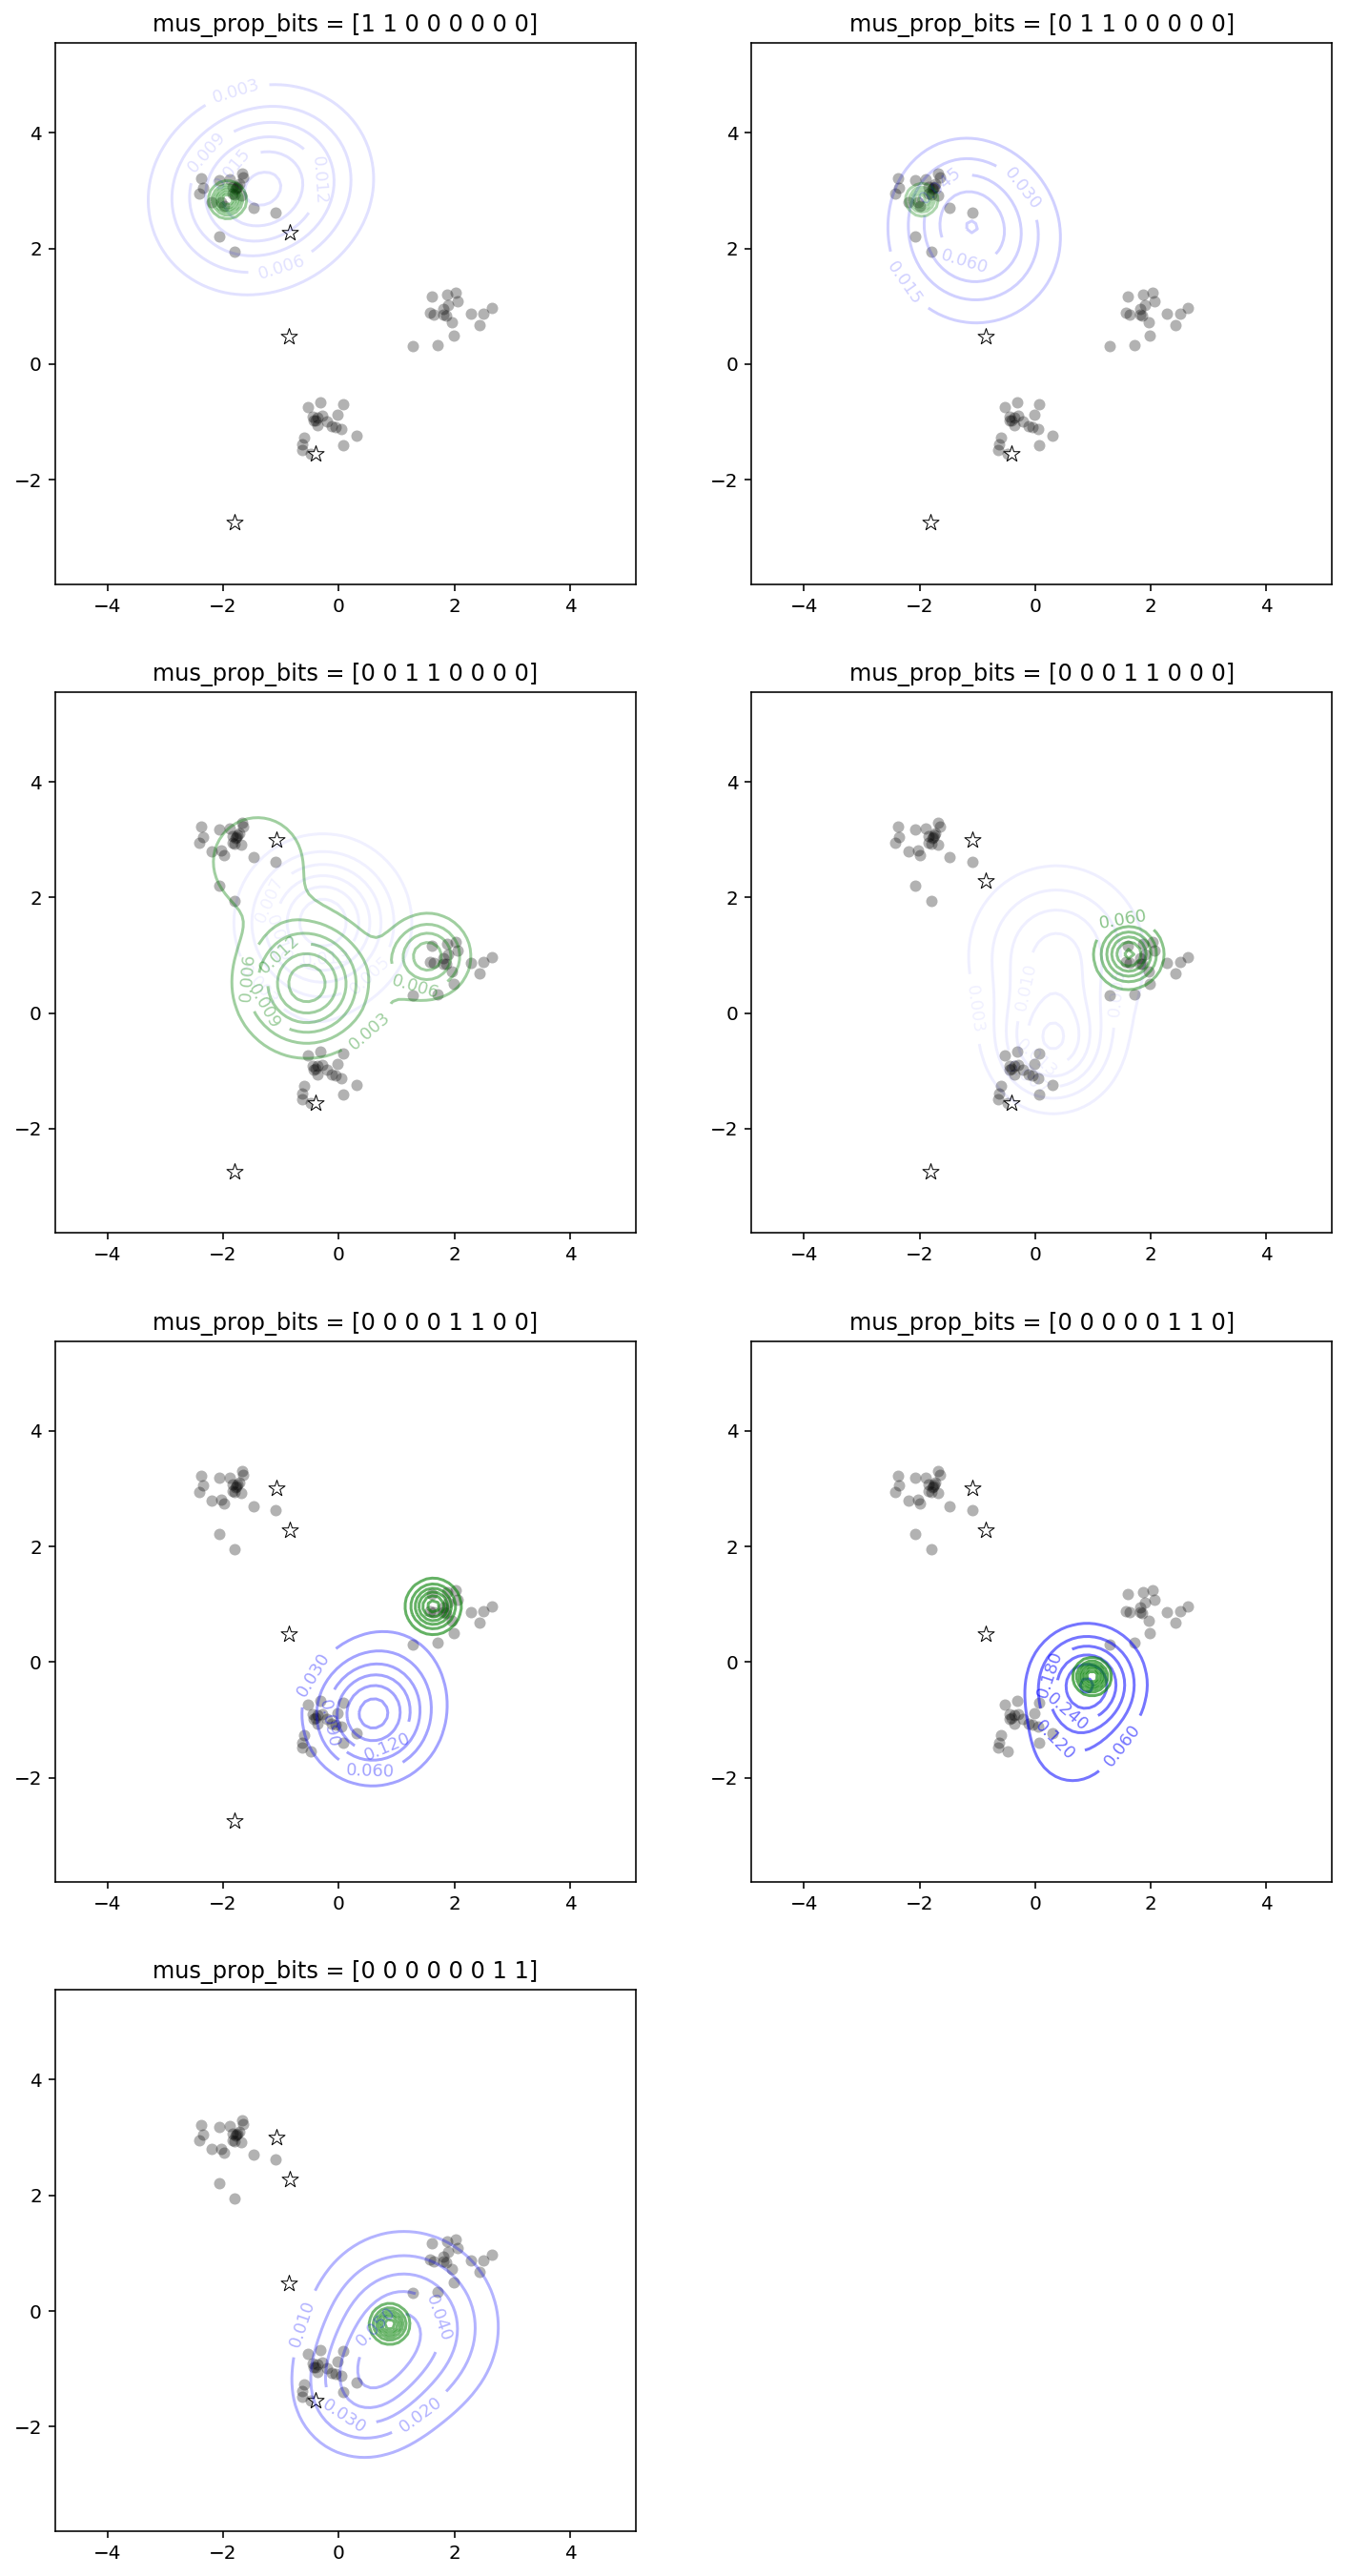

In [12]:
test_pretrain_visualize()

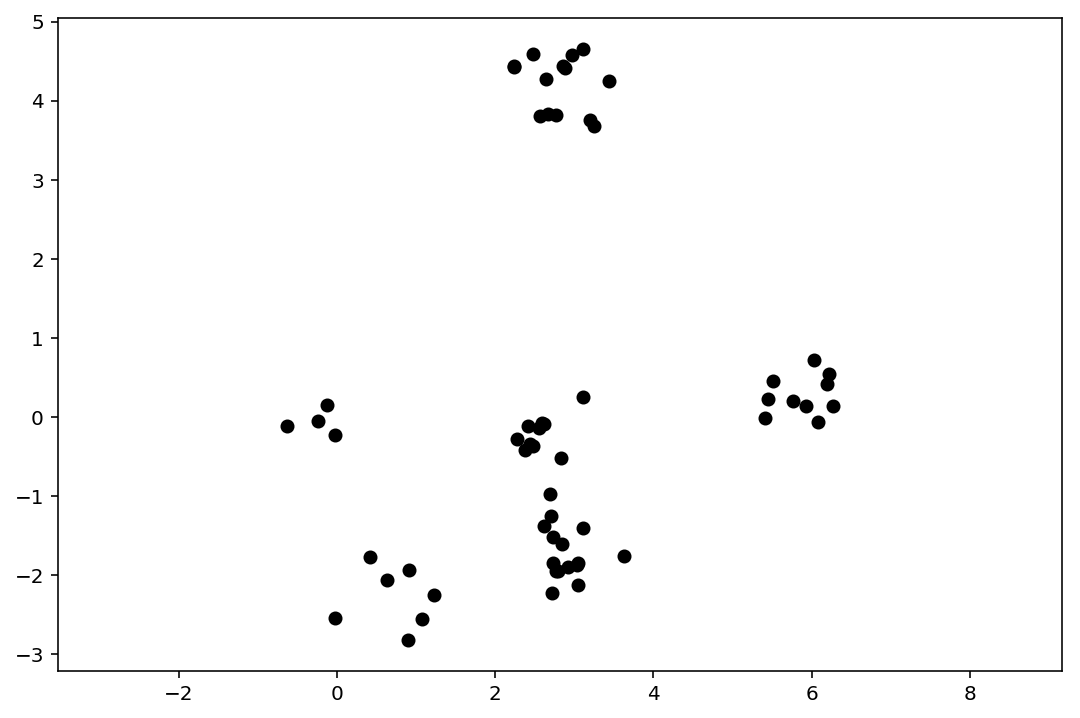

In [30]:
samples = Cs, mus, mus_valid_bits, zs, xs, Ws, offsets = sample(1, Cs = 6, sort_pca = True)
scatter_xs(xs)

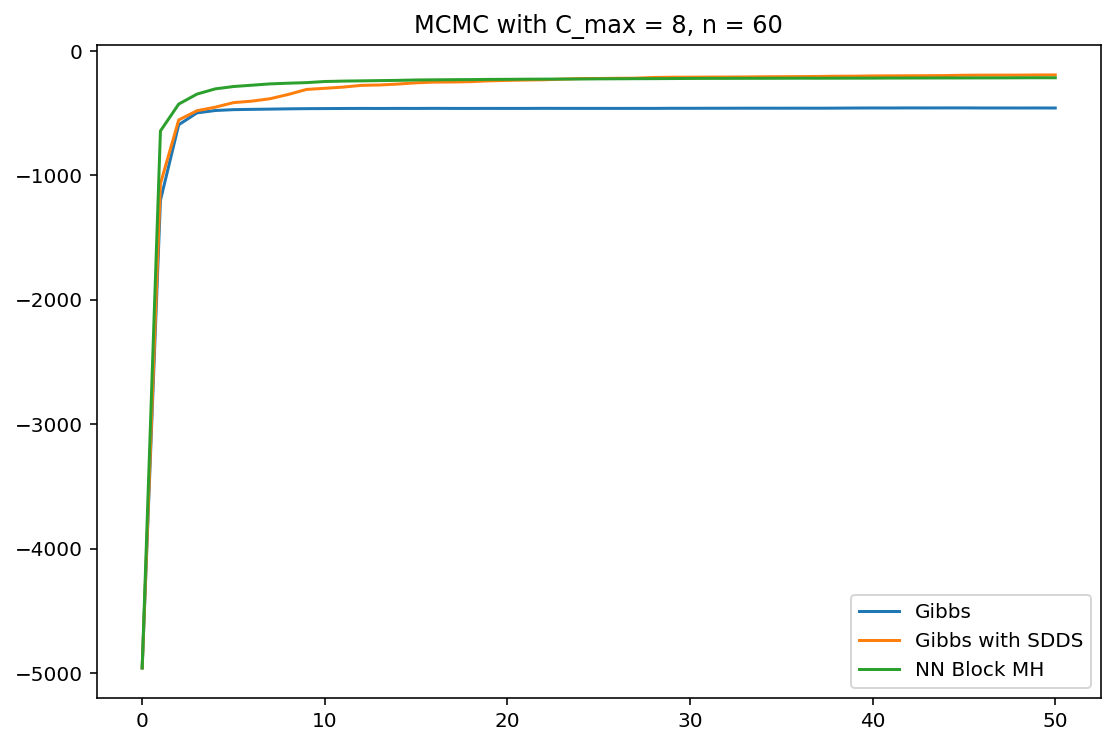

In [ ]:
xxs = sample(200)[-1]
inits = sample(200, sort_pca = True)
plotter = LinePlotter('MCMC with {}'.format(default_params), 'linear')
init_fn = lambda k, p: tuple(v.copy() for v in inits)
gibbs(xxs, init_fn = init_fn, plotter = plotter, burn_in = 50, num_samples = 0, sdds= False)
gibbs(xxs, init_fn = init_fn, plotter = plotter, burn_in = 50, num_samples = 0, sdds= True)
nn_block_mh(xxs, init_fn = init_fn, plotter = plotter, burn_in = 50, num_samples = 0)
plotter.finish_all()

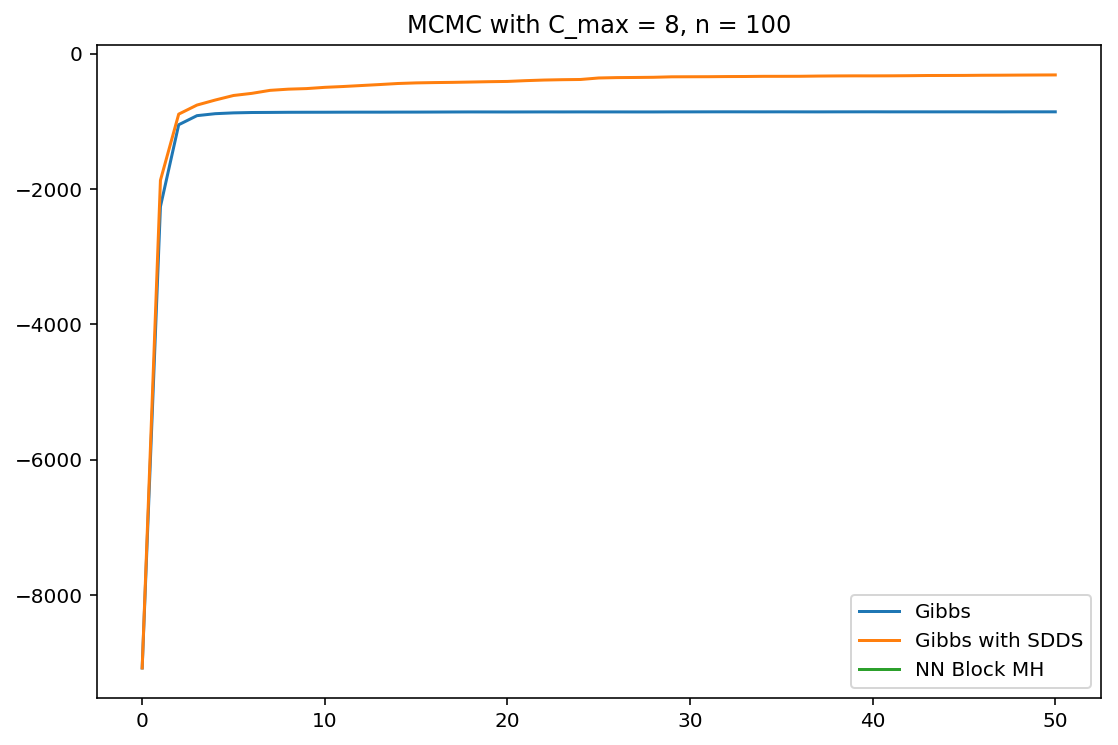

In [ ]:
xxs = sample(200, params = more_xs_params)[-1]
inits = sample(200, sort_pca = True, params = more_xs_params)
plotter = LinePlotter('MCMC with {}'.format(more_xs_params), 'linear')
init_fn = lambda k, p: tuple(v.copy() for v in inits)
gibbs(xxs, init_fn = init_fn, plotter = plotter, burn_in = 50, num_samples = 0, sdds= False, params = more_xs_params)
gibbs(xxs, init_fn = init_fn, plotter = plotter, burn_in = 50, num_samples = 0, sdds= True, params = more_xs_params)
nn_block_mh(xxs, init_fn = init_fn, plotter = plotter, burn_in = 50, num_samples = 0, params = more_xs_params)
plotter.finish_all()

In [ ]:
xxs = sample(200, params = extended_params)[-1]
inits = sample(200, sort_pca = True, params = extended_params)
plotter = LinePlotter('MCMC with {}'.format(extended_params), 'linear')
init_fn = lambda k, p: tuple(v.copy() for v in inits)
gibbs(xxs, init_fn = init_fn, plotter = plotter, burn_in = 50, num_samples = 0, sdds= False, params = extended_params)
gibbs(xxs, init_fn = init_fn, plotter = plotter, burn_in = 50, num_samples = 0, sdds= True, params = extended_params)
nn_block_mh(xxs, init_fn = init_fn, plotter = plotter, burn_in = 50, num_samples = 0, params = extended_params)
plotter.finish_all()

# Default params

In [282]:
default_params

Params(C_max = 8, n = 60)

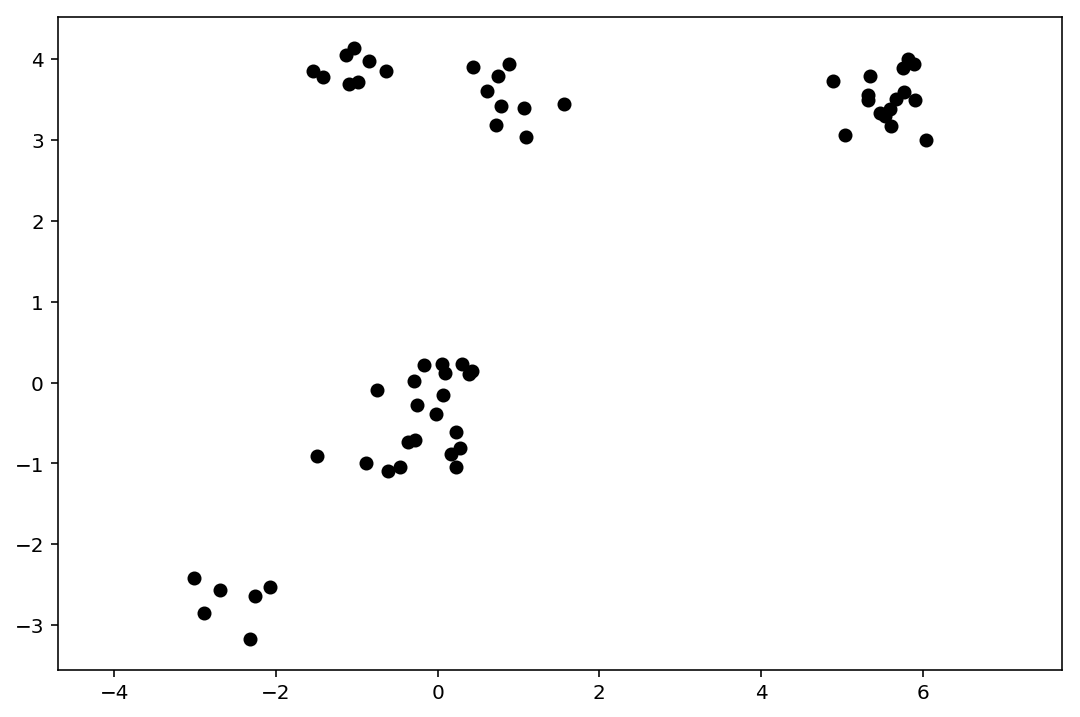

In [297]:
samples = sample(1, Cs = 6, sort_pca = True)
scatter_xs(samples[-3])

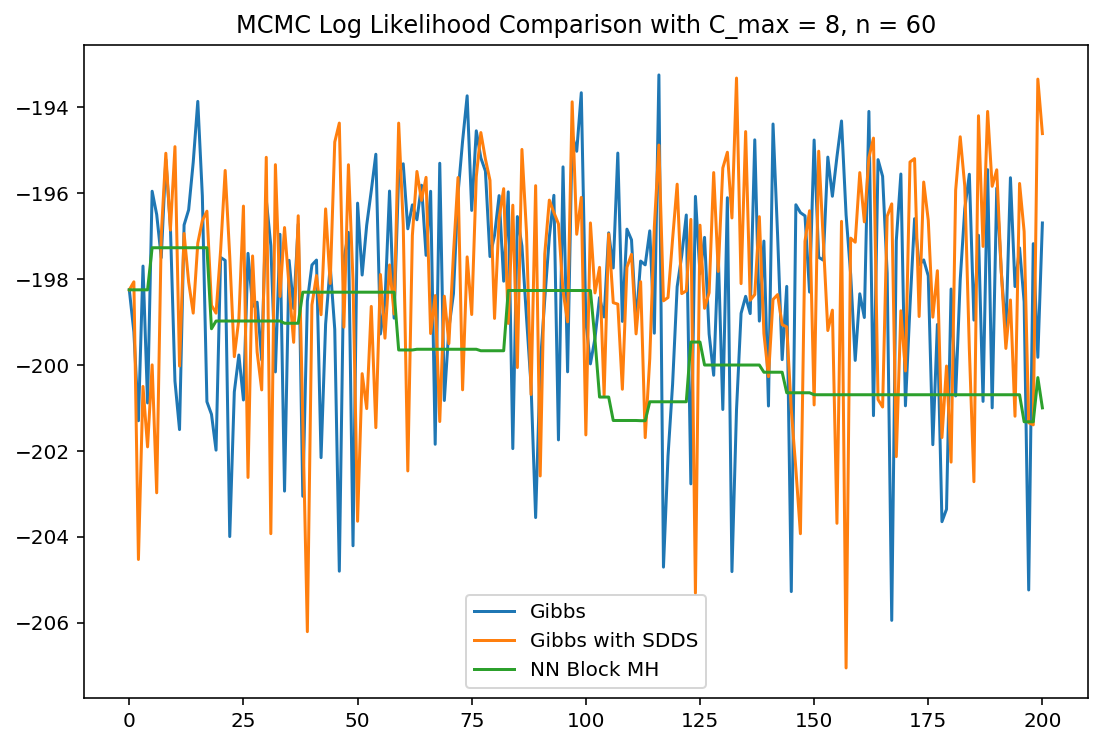

In [298]:
# ground truth initialization
compare_mcmc(
    samples[-3], 
    init_fn = lambda _: samples, 
    burn_in = 200, 
    num_samples = 0,
)

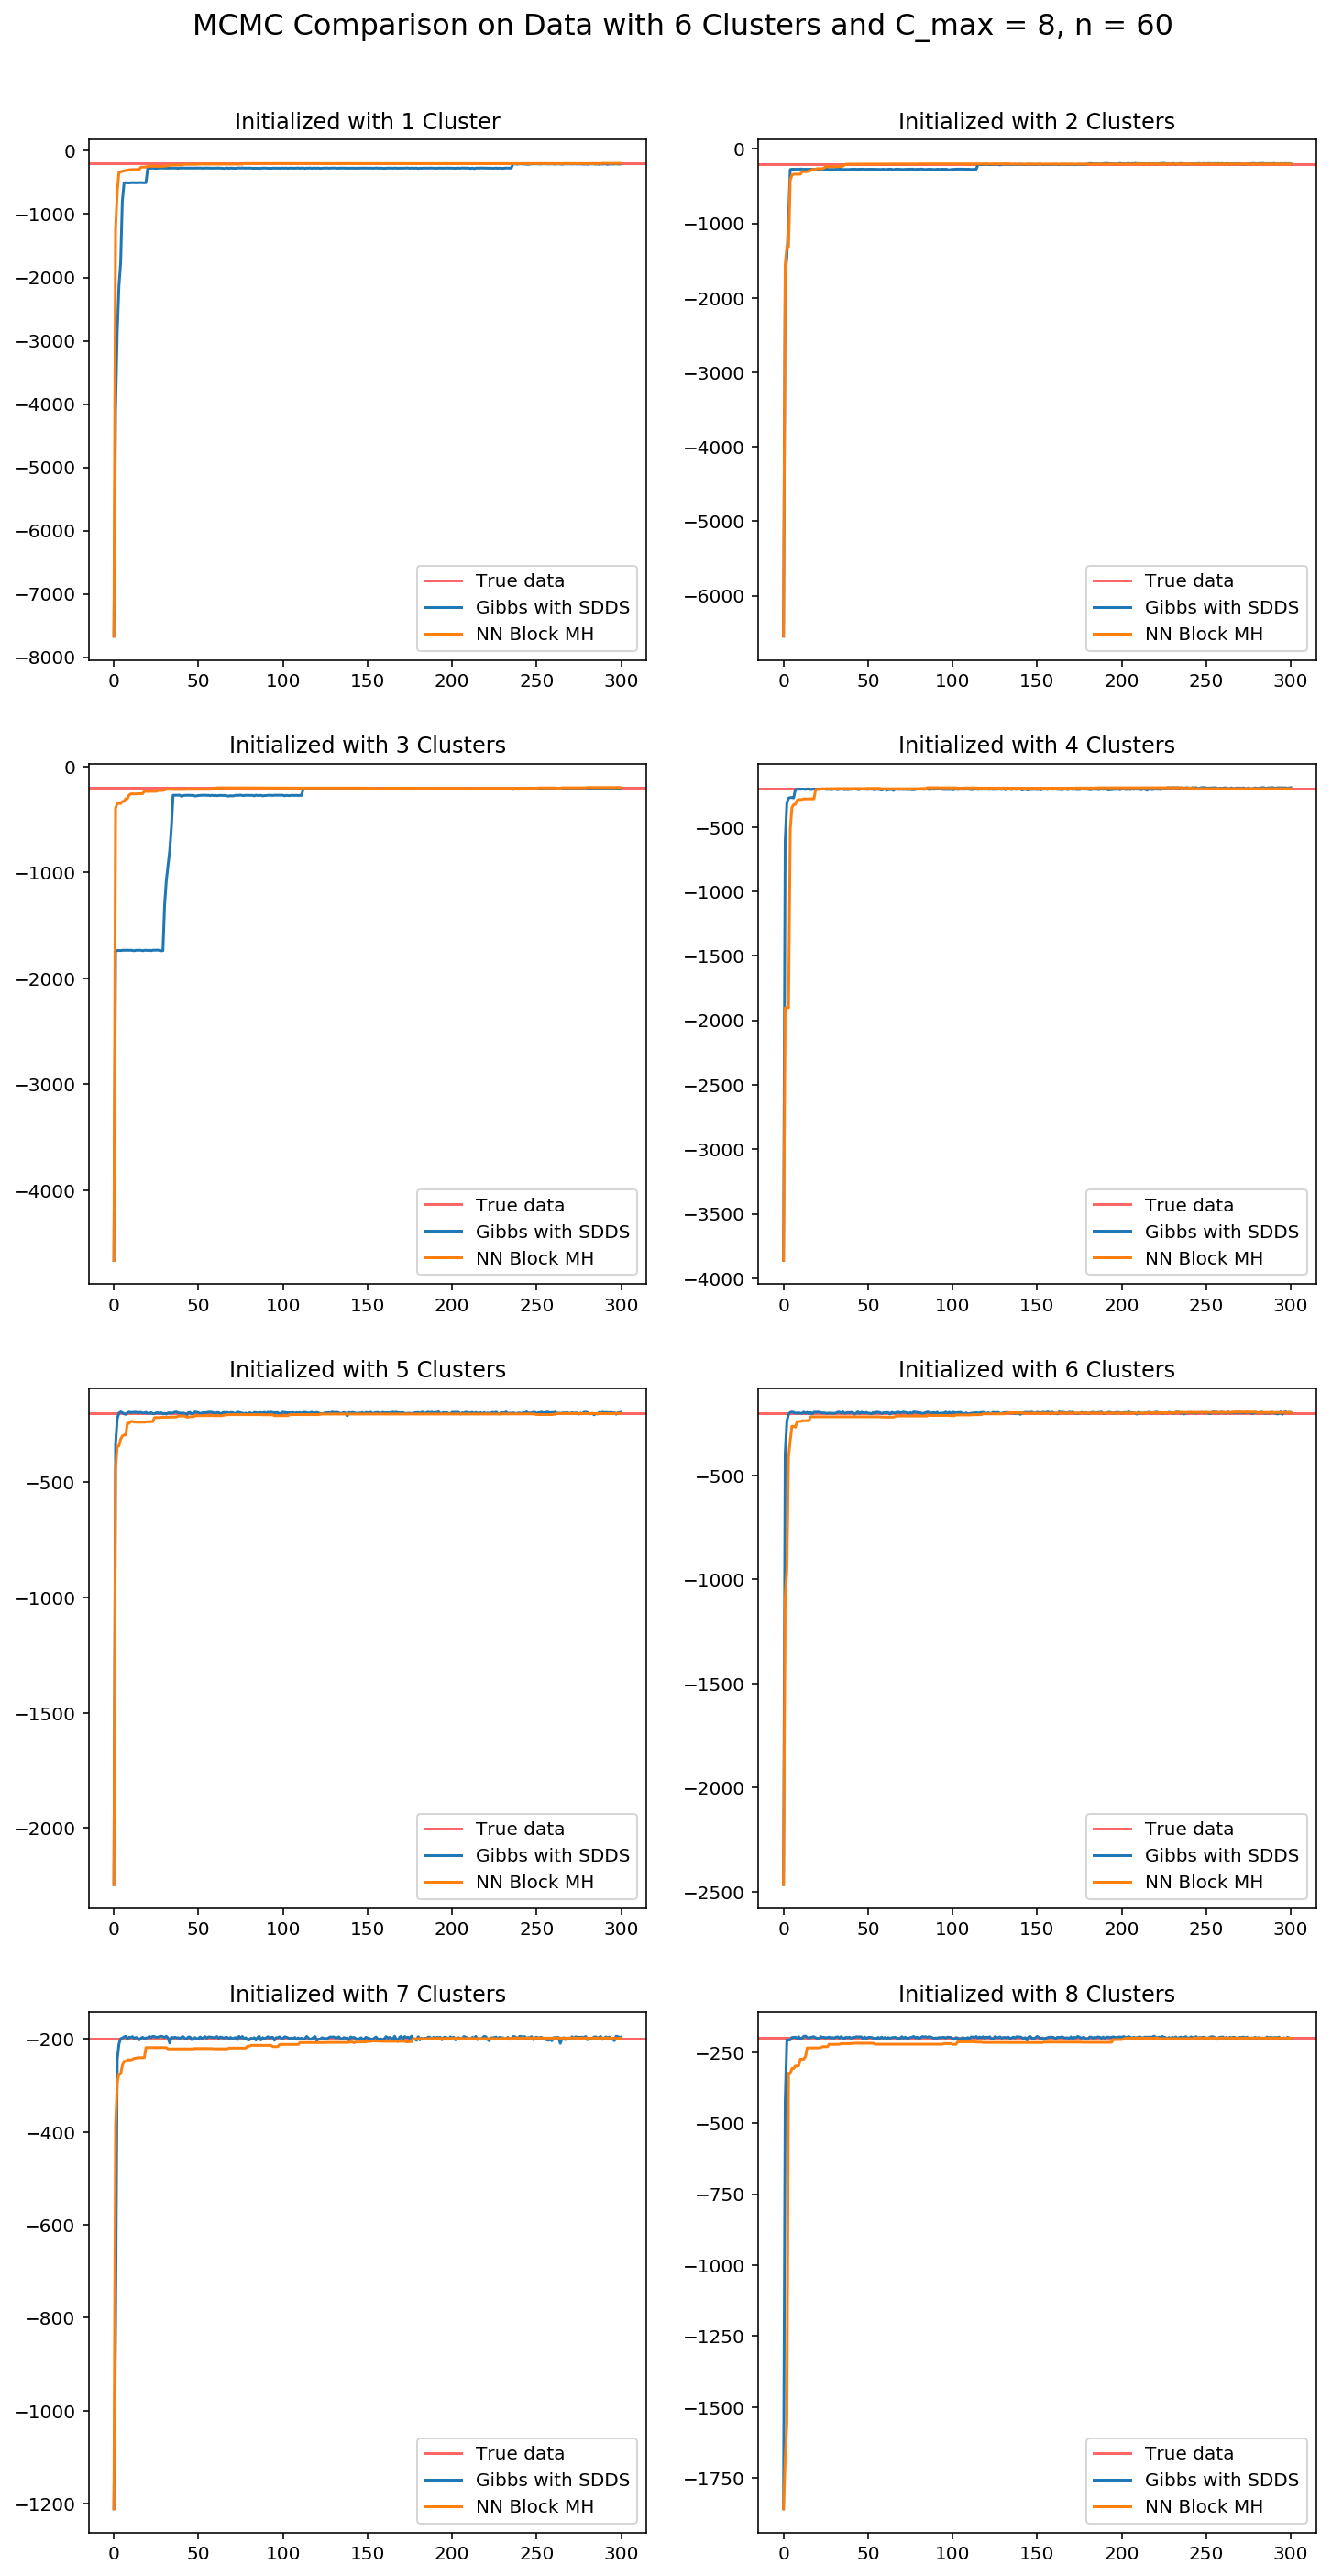

In [299]:
_ = compare_mcmc_different_init_clusters(
    samples,
    burn_in = 300,
    num_samples = 0,
)

In [300]:
K = 100

mcmc_params = dict(
    burn_in = 500, 
    num_samples = 5, 
    sample_int = 20, 
    plotter = None,
)

mcmc_fns = [gibbs, nn_block_mh]

mcmc_sample_colls = [[] for _ in mcmc_fns]

for mcmc_fn, mcmc_samples in zip(mcmc_fns, mcmc_sample_colls):
    print("Running {}...".format(mcmc_fn.__name__))
    for k in range(K):
        print("\r{}/{}".format(k, K), end = "")
        mcmc_samples.append(mcmc_fn(samples[-3], **mcmc_params))
    print("\r\033[Kdone!")

Running gibbs...
done!
Running nn_block_mh...
done!


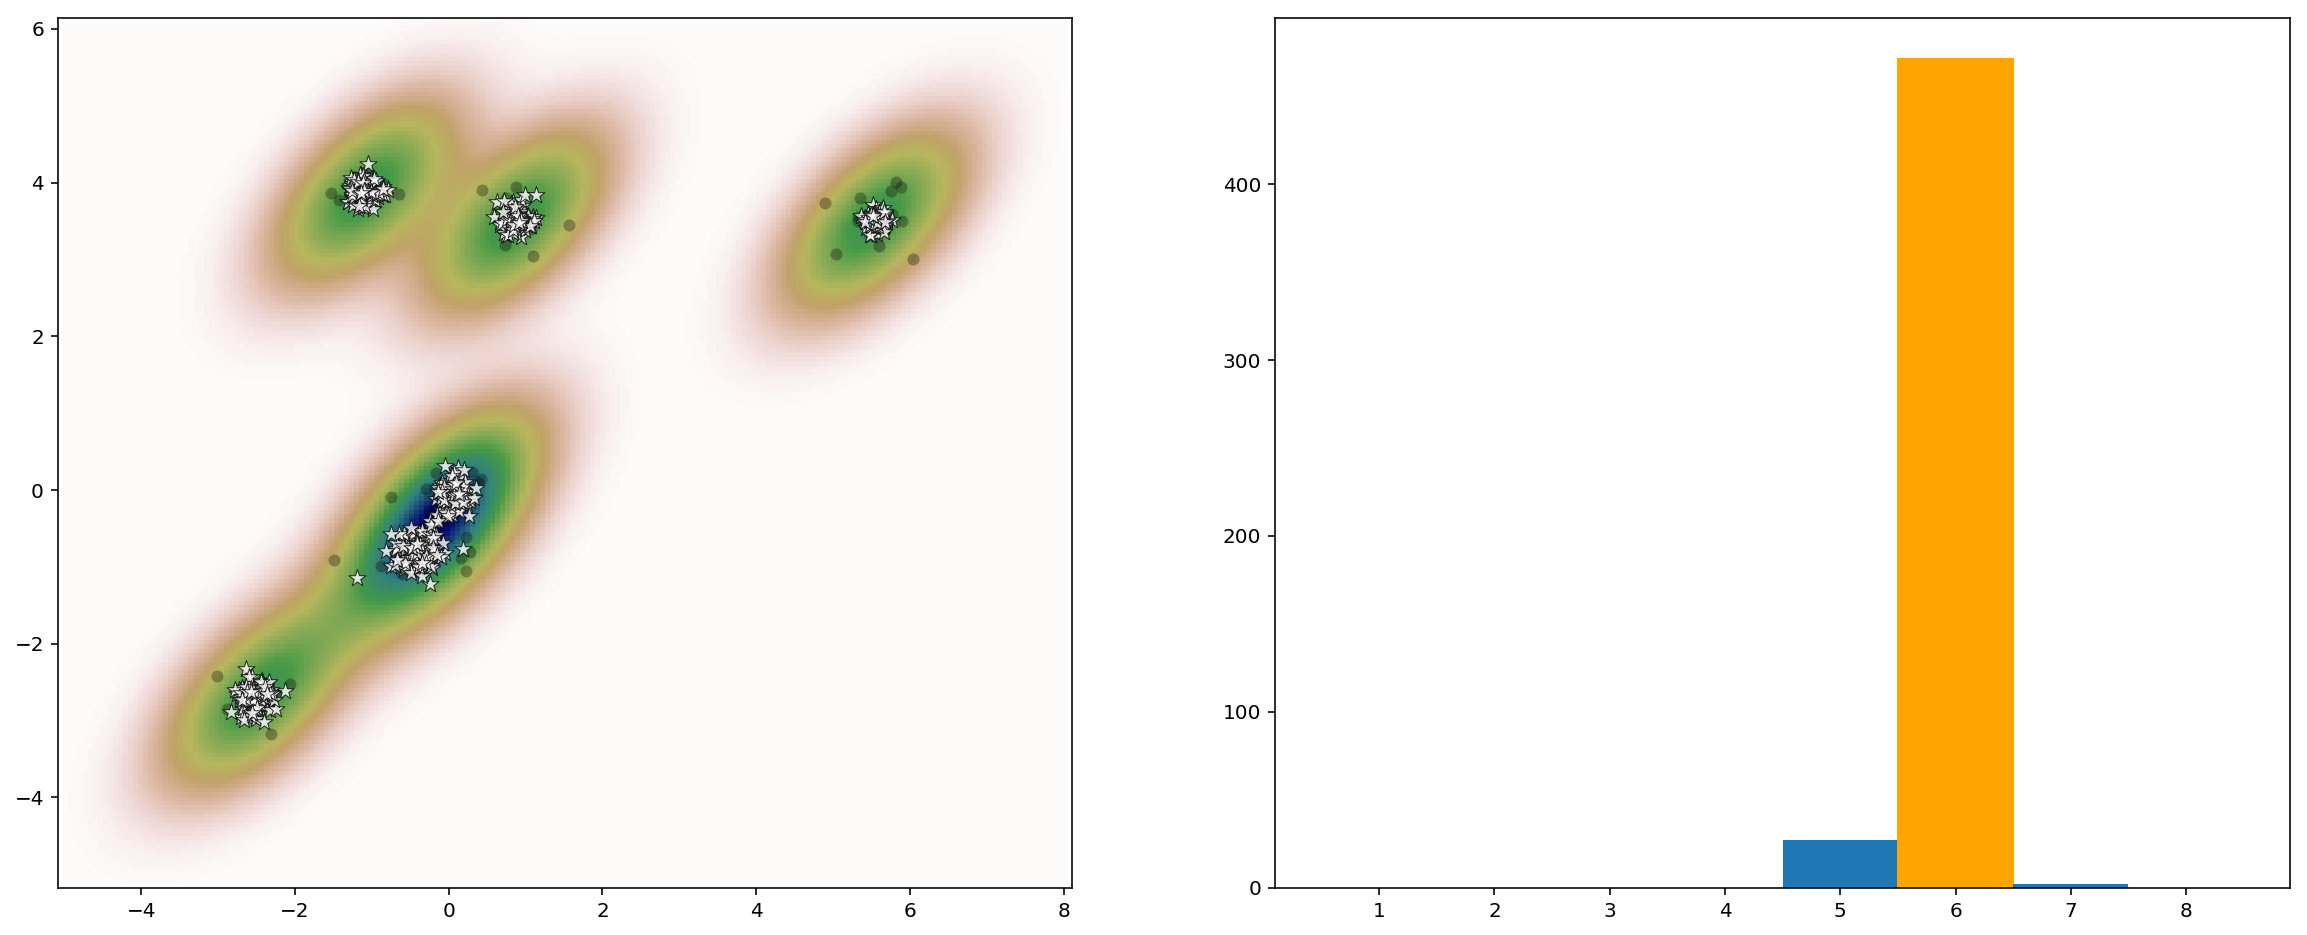

In [303]:
fig, axs = plt.subplots(1, 2, figsize= (20, 8))
sample_mus_kde(samples[-3], mcmc_sample_colls[0], gaussian_bw = 0.3, delta = 200j, ax = axs[0])
sample_Cs_hist(samples[0], mcmc_sample_colls[0], ax = axs[1])
plt.show()

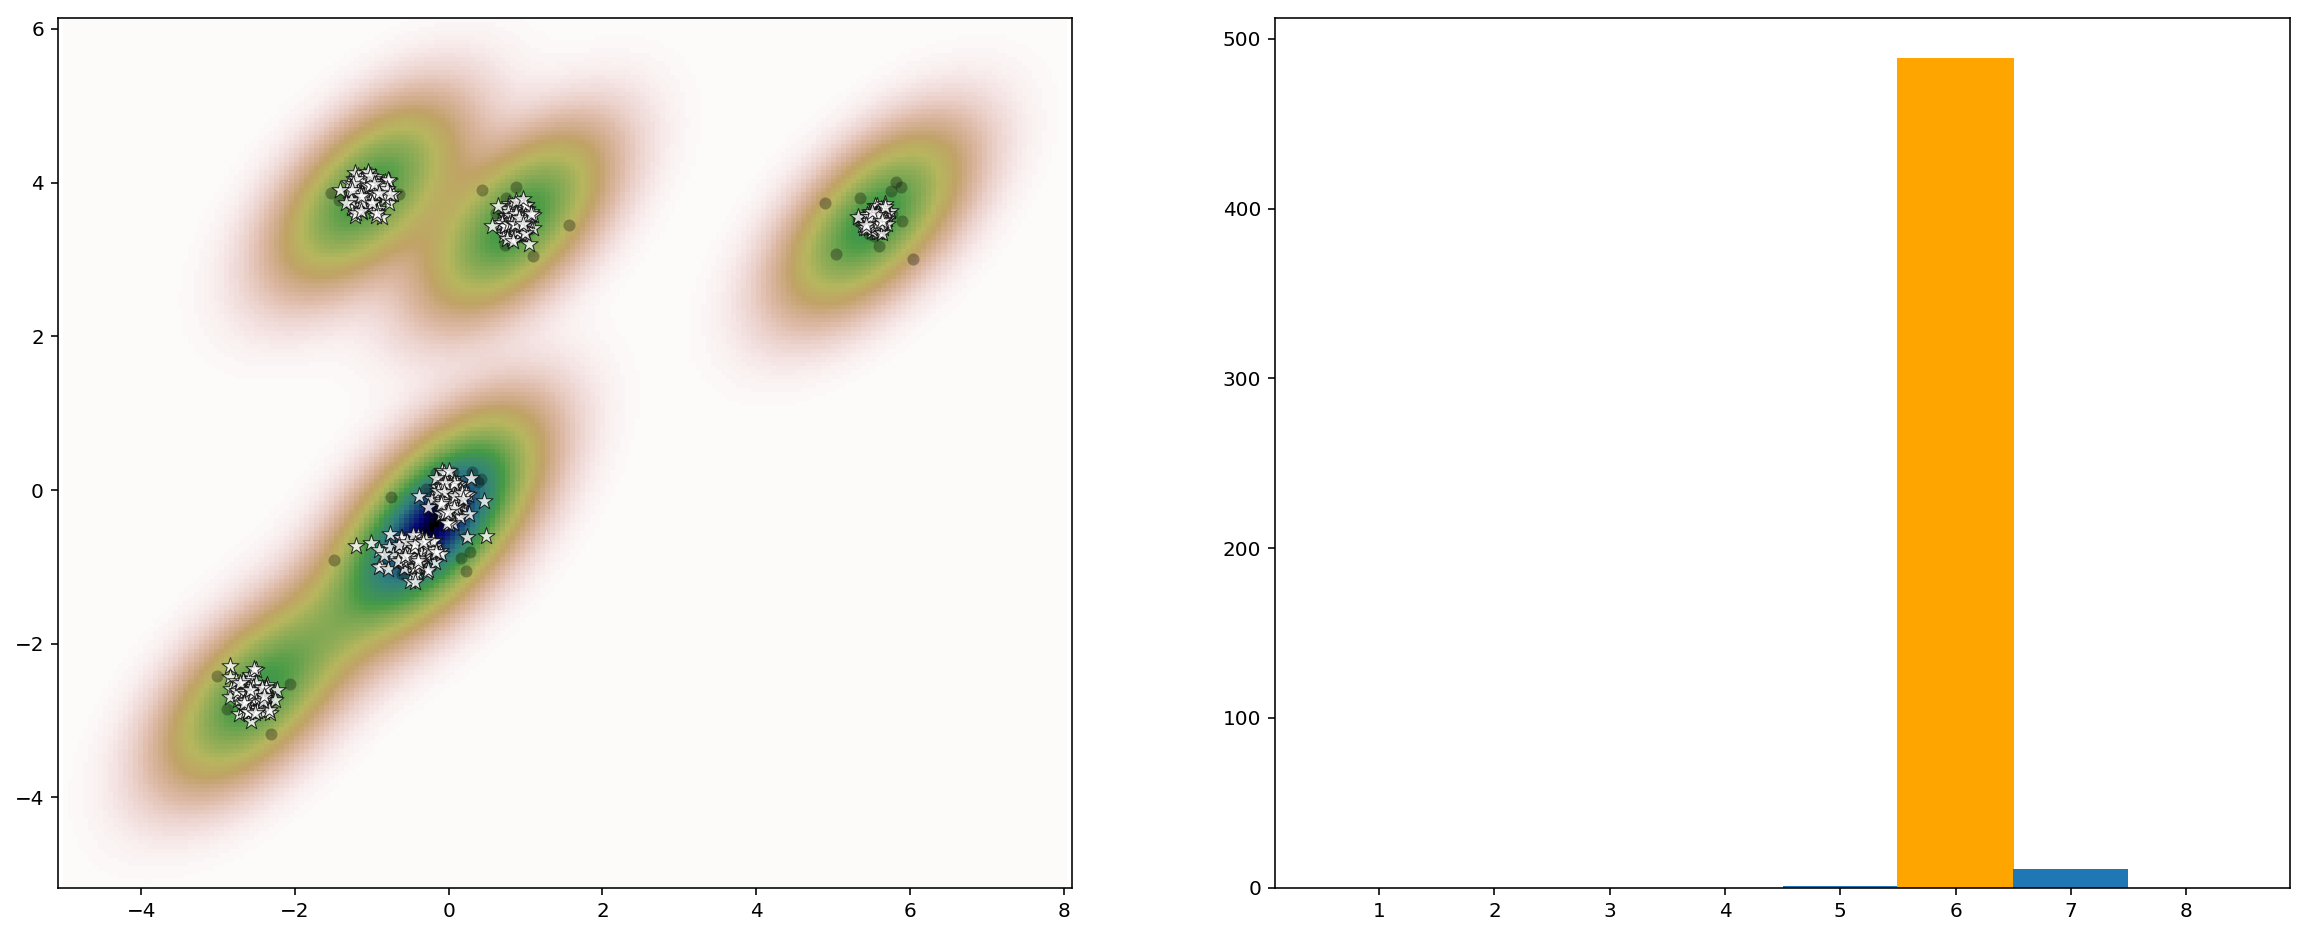

In [304]:
fig, axs = plt.subplots(1, 2, figsize= (20, 8))
sample_mus_kde(samples[-3], mcmc_sample_colls[1], gaussian_bw = 0.3, delta = 200j, ax = axs[0])
sample_Cs_hist(samples[0], mcmc_sample_colls[1], ax = axs[1])
plt.show()

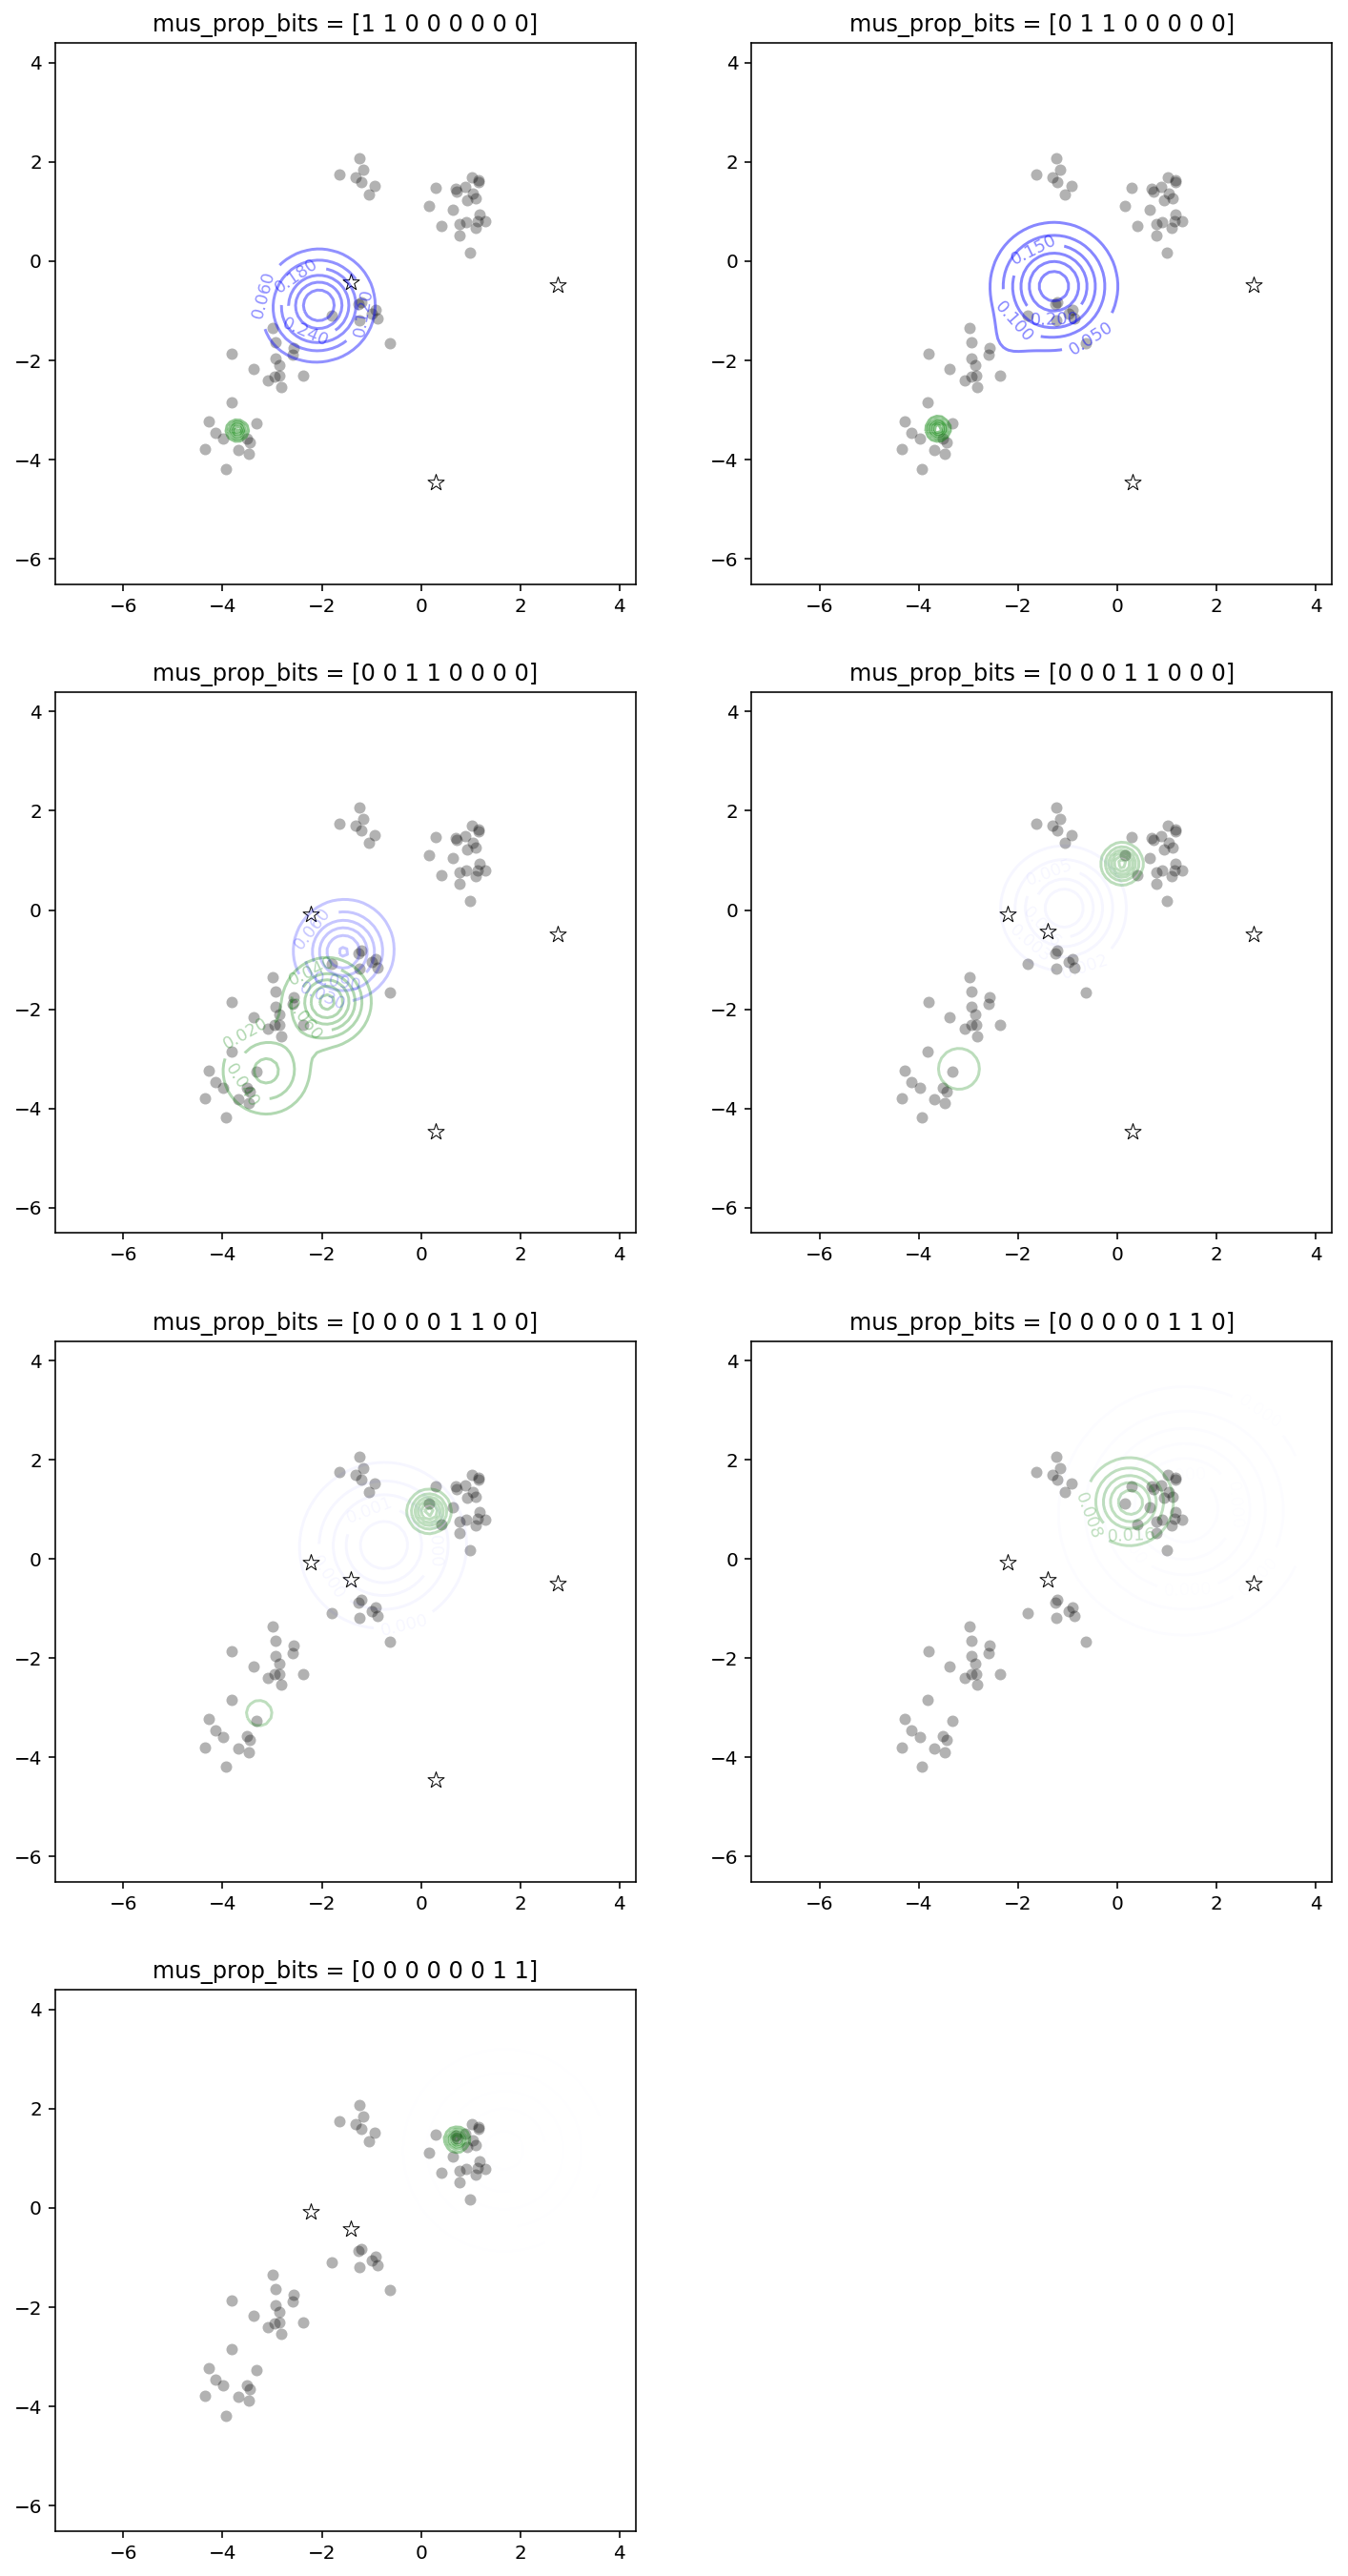

In [49]:
test_pretrain_visualize(true_samples = samples)

## Same #cluter, more #points

In [305]:
more_xs_params

Params(C_max = 8, n = 100)

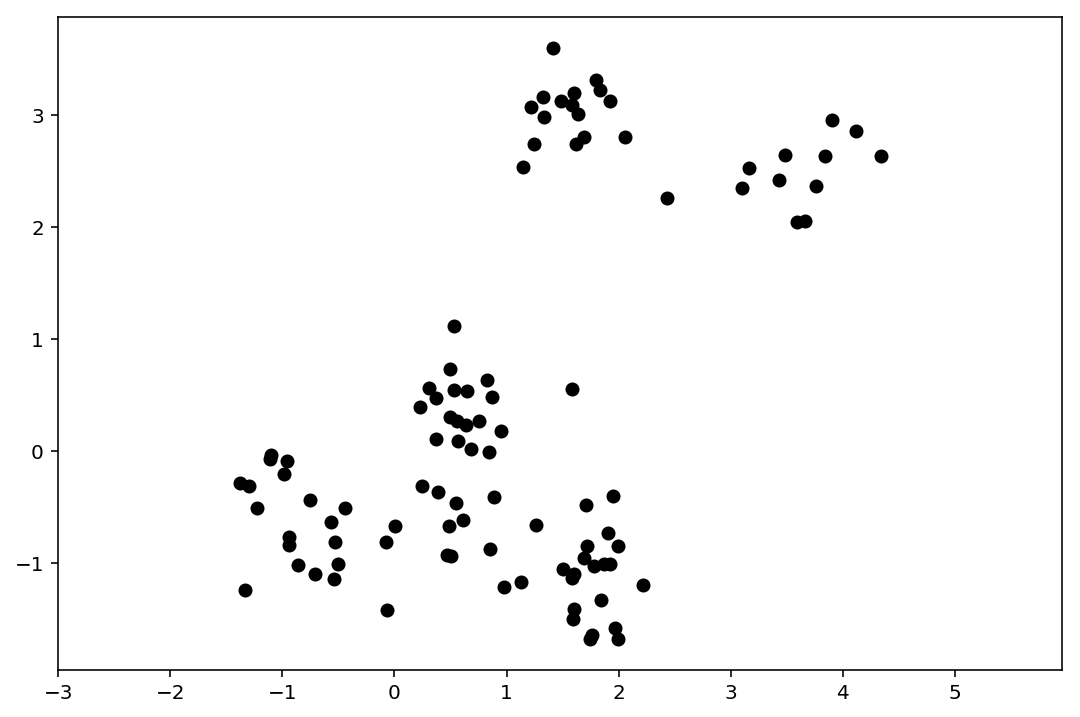

In [306]:
more_xs_samples = sample(1, Cs = 6, sort_pca = True, params = more_xs_params)
scatter_xs(more_xs_samples[-3])

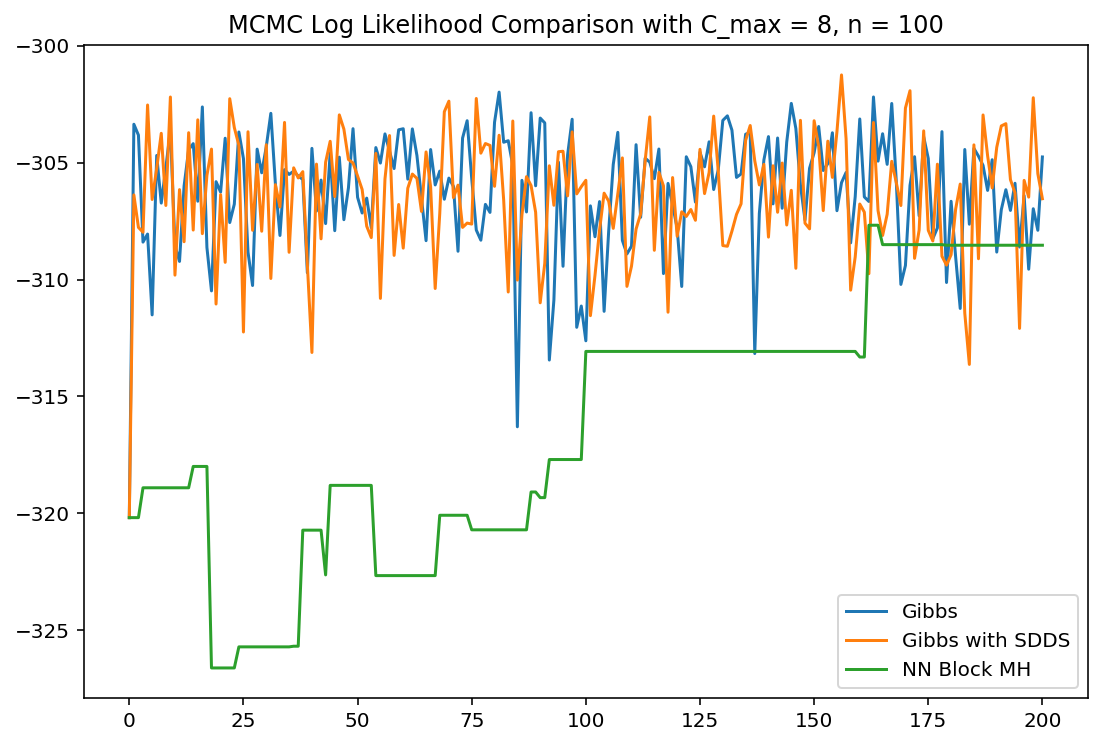

In [308]:
# ground truth initialization
compare_mcmc(
    more_xs_samples[-3], 
    init_fn = lambda _: more_xs_samples, 
    burn_in = 200, 
    num_samples = 0,
    params = more_xs_params
)

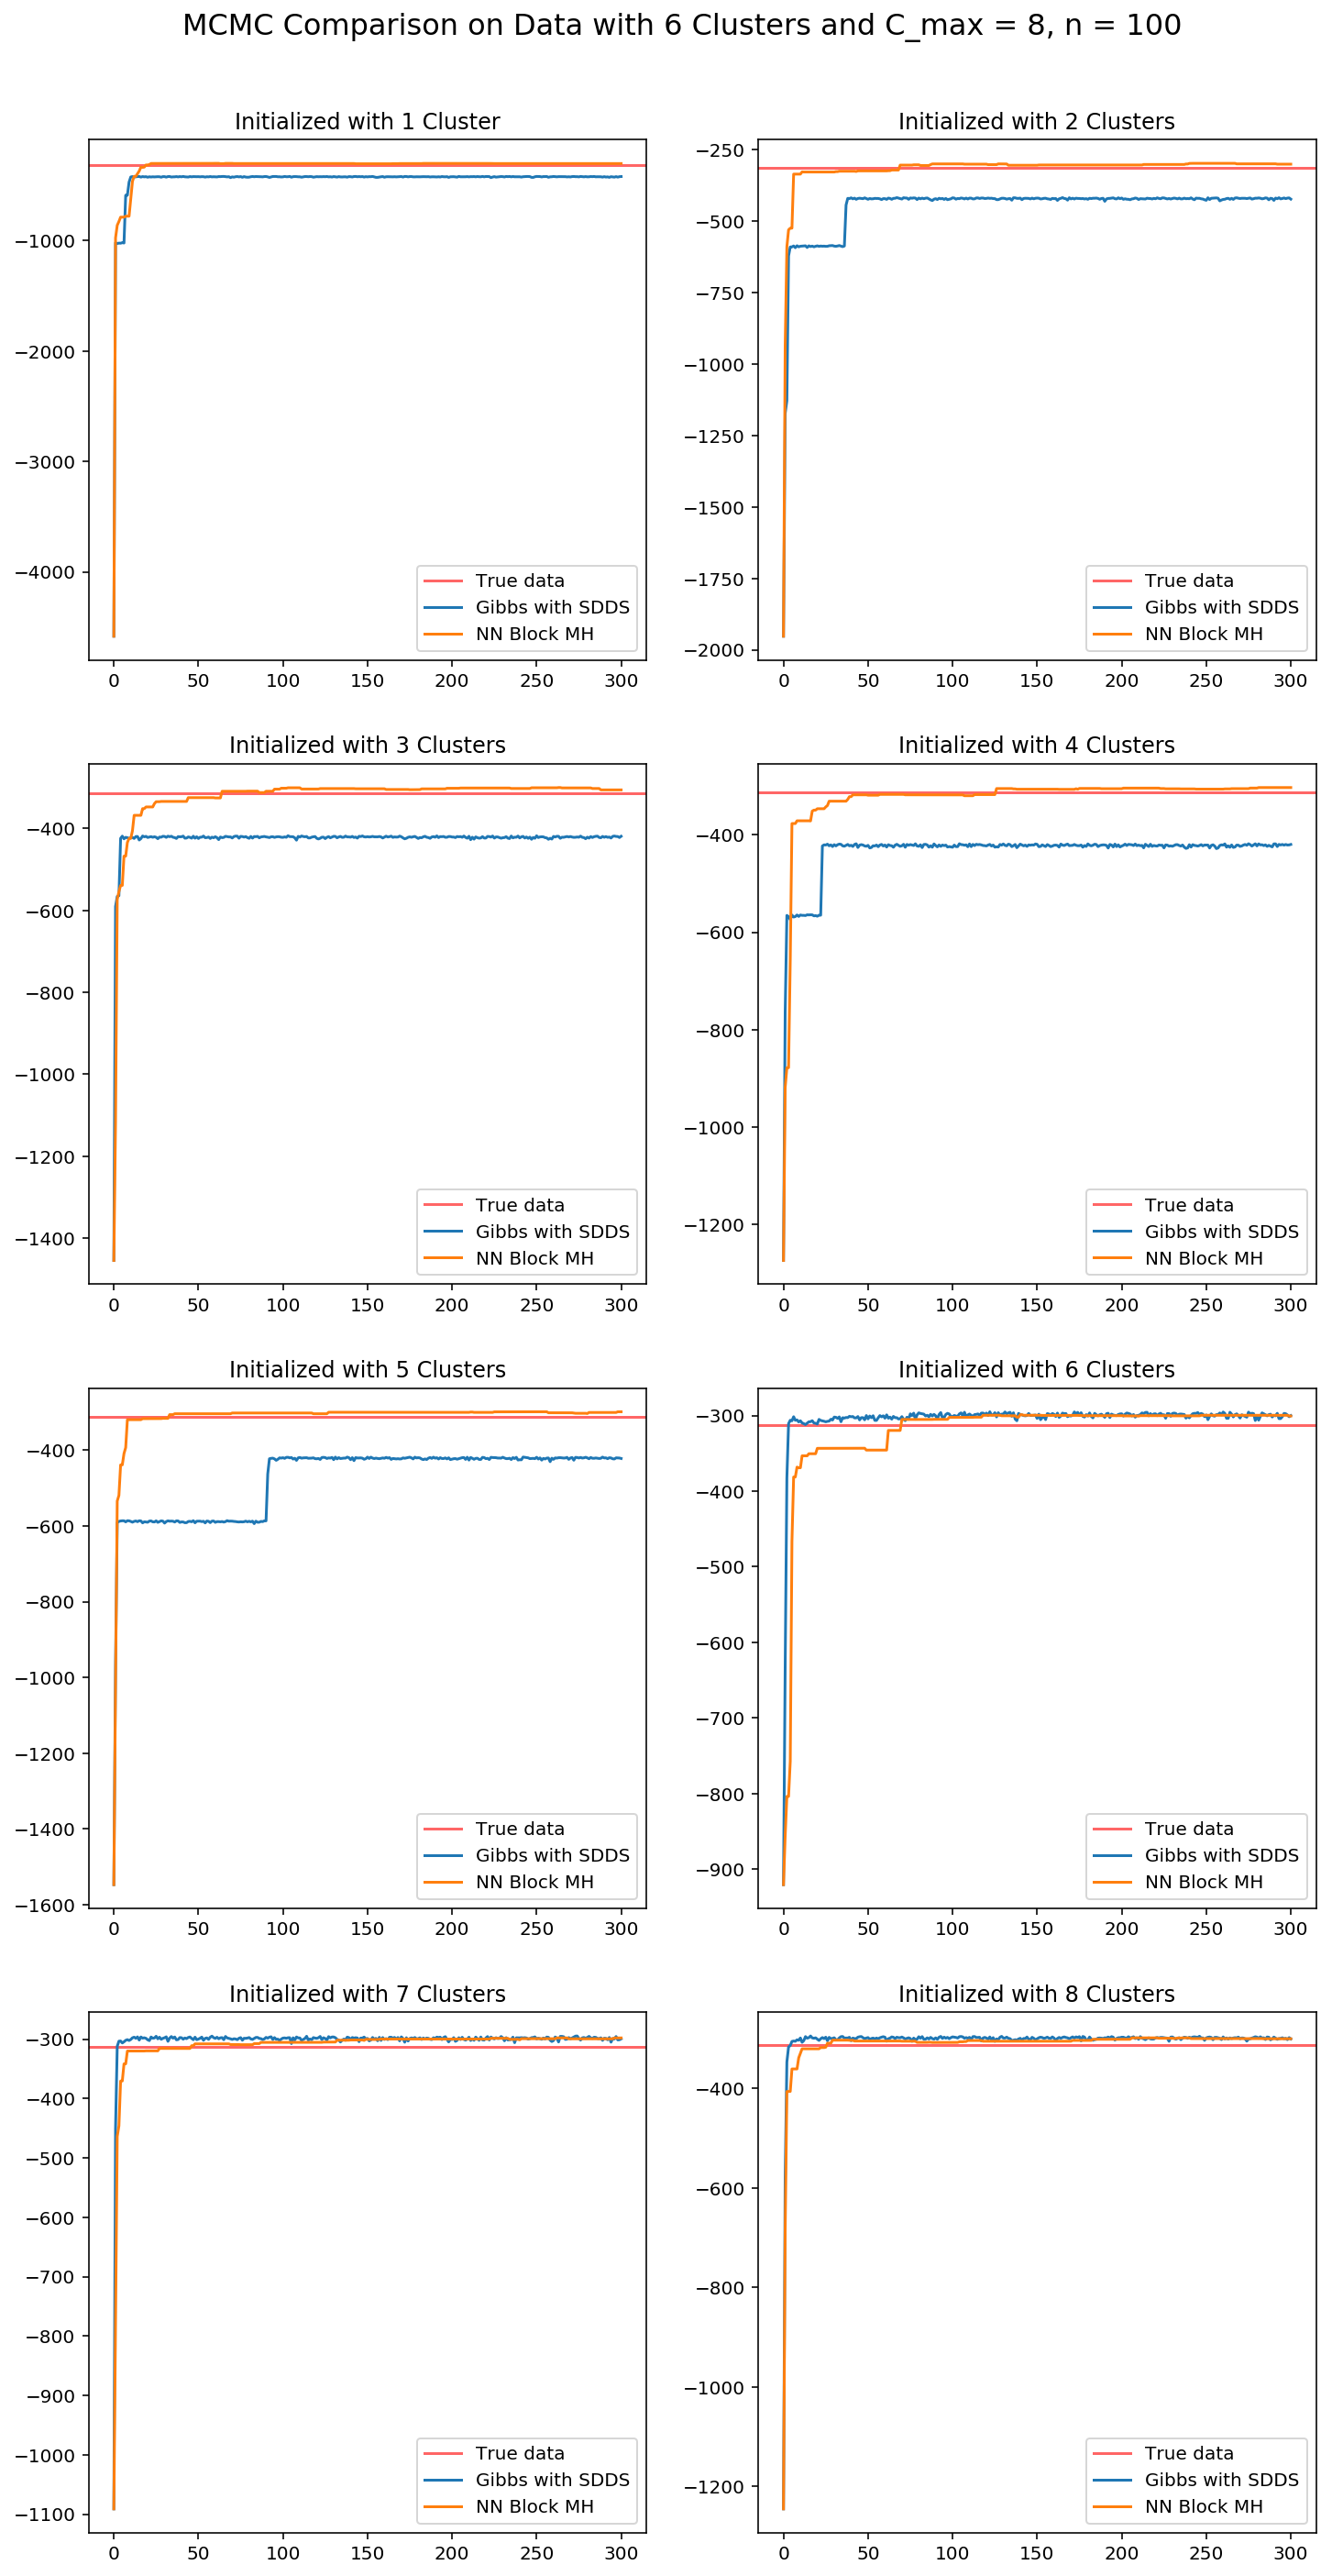

In [260]:
_ = compare_mcmc_different_init_clusters(
    more_xs_samples,
    burn_in = 300,
    num_samples = 0,
    params = more_xs_params,
)

In [310]:
K = 100

mcmc_params = dict(
    burn_in = 500, 
    num_samples = 5, 
    sample_int = 20, 
    plotter = None,
    params = more_xs_params,
)

mcmc_fns = [gibbs, nn_block_mh]

mcmc_sample_colls = [[] for _ in mcmc_fns]

for mcmc_fn, mcmc_samples in zip(mcmc_fns, mcmc_sample_colls):
    print("Running {}...".format(mcmc_fn.__name__))
    for k in range(K):
        print("\r{}/{}".format(k, K), end = "")
        mcmc_samples.append(mcmc_fn(more_xs_samples[-3], **mcmc_params))
    print("\r\033[Kdone!")

Running gibbs...
done!
Running nn_block_mh...
done!


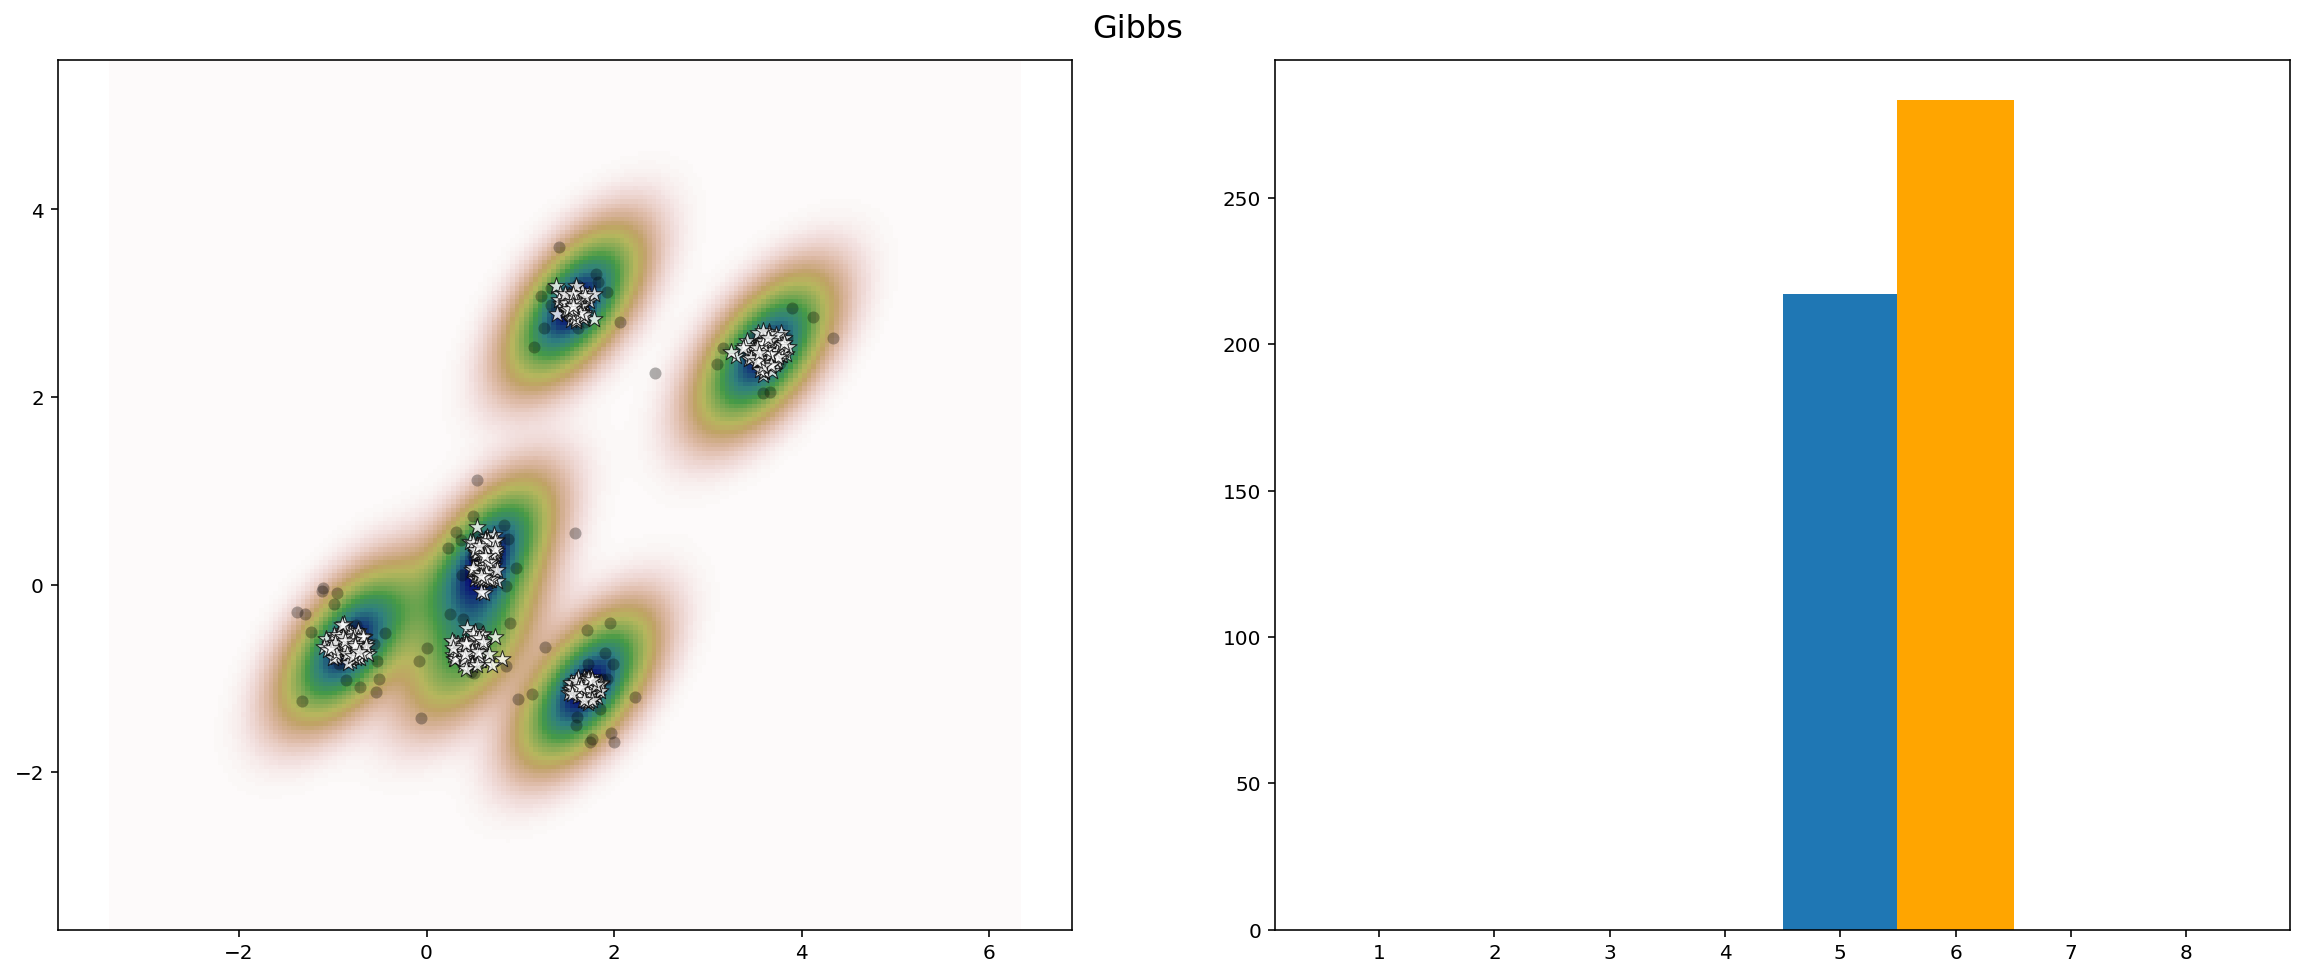

In [311]:
fig, axs = plt.subplots(1, 2, figsize= (20, 8))
fig.suptitle("Gibbs", fontsize = 16, y = 0.92)
sample_mus_kde(more_xs_samples[-3], mcmc_sample_colls[0], gaussian_bw = 0.3, delta = 200j, ax = axs[0])
sample_Cs_hist(more_xs_samples[0], mcmc_sample_colls[0], ax = axs[1])
plt.show()

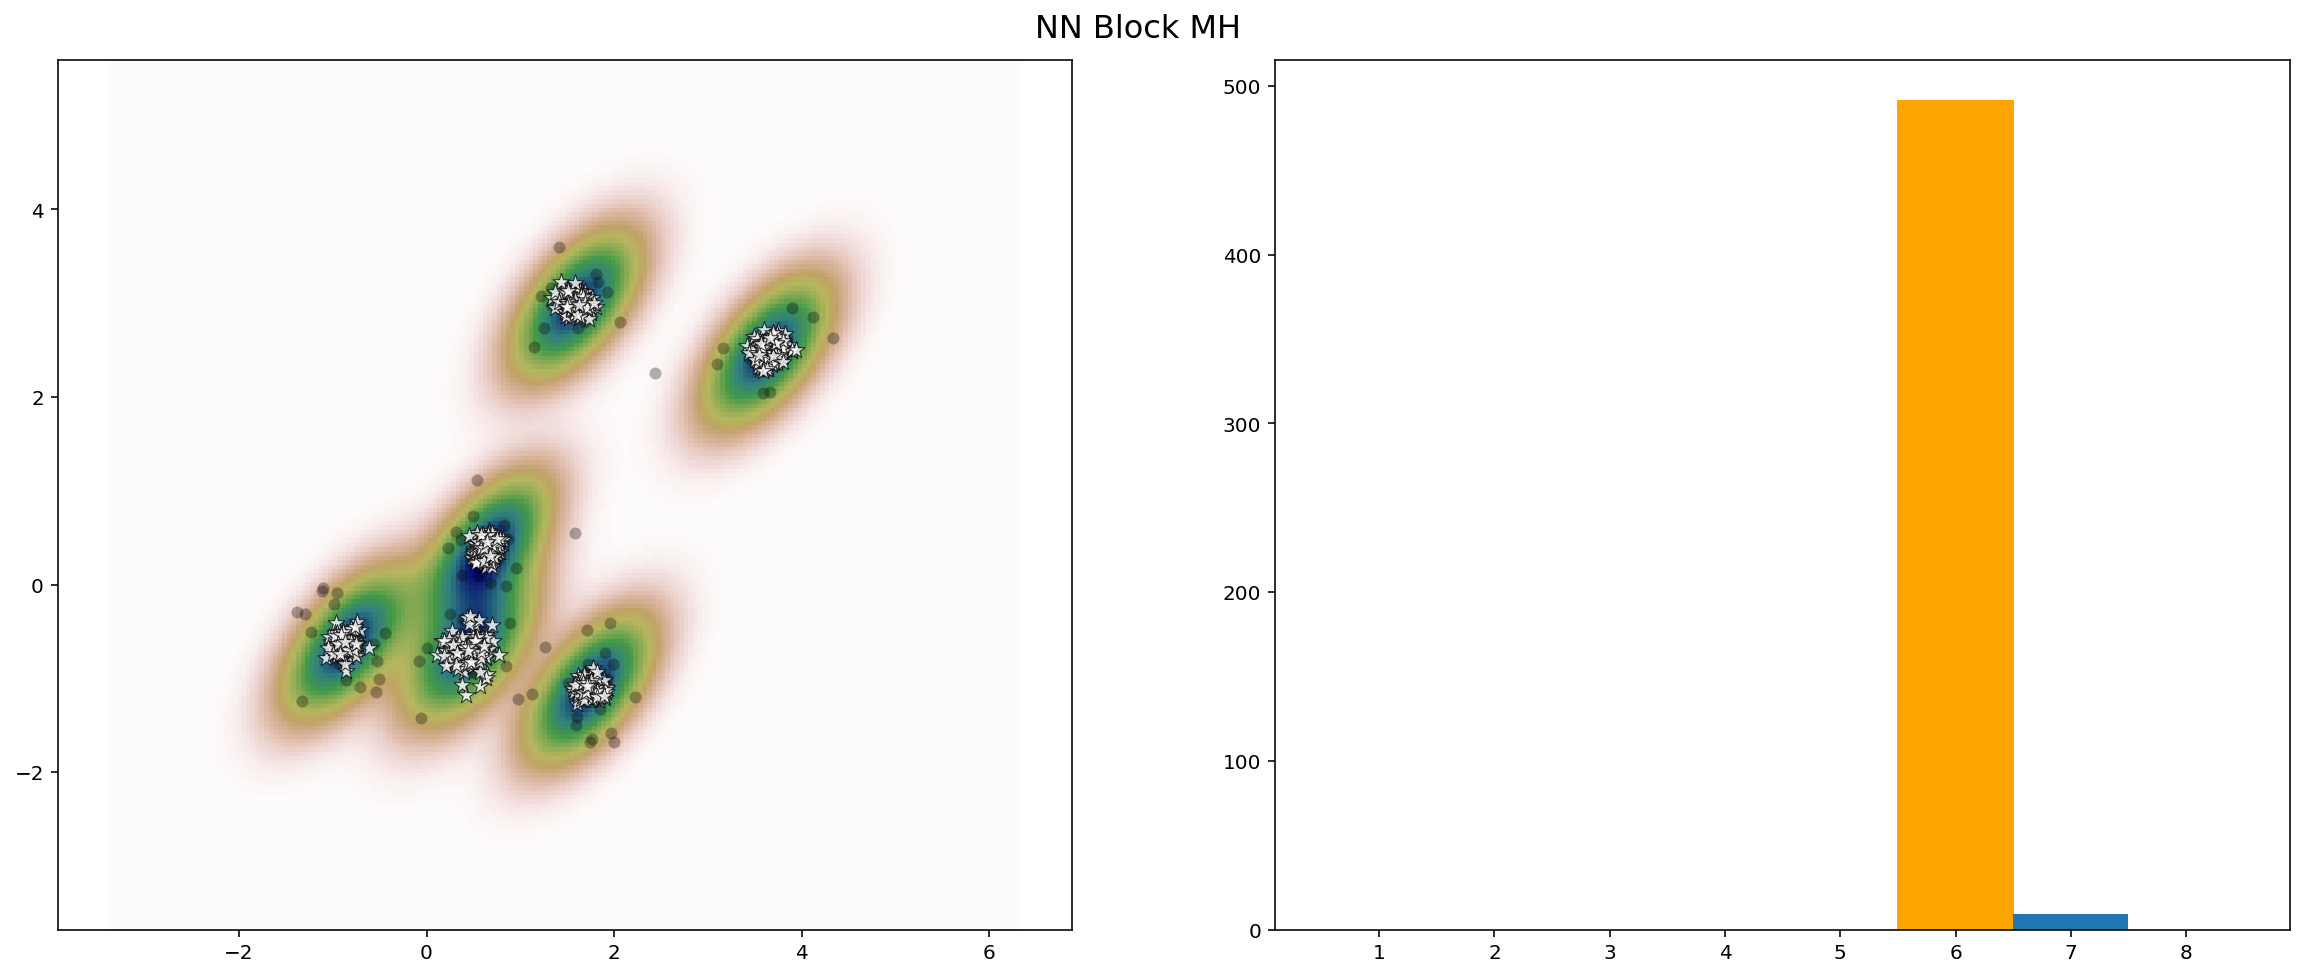

In [312]:
fig, axs = plt.subplots(1, 2, figsize= (20, 8))
fig.suptitle("NN Block MH", fontsize = 16, y = 0.92)
sample_mus_kde(more_xs_samples[-3], mcmc_sample_colls[1], gaussian_bw = 0.3, delta = 200j, ax = axs[0])
sample_Cs_hist(more_xs_samples[0], mcmc_sample_colls[1], ax = axs[1])
plt.show()

## More #cluster, more #points

In [313]:
extended_params

Params(C_max = 24, n = 180)

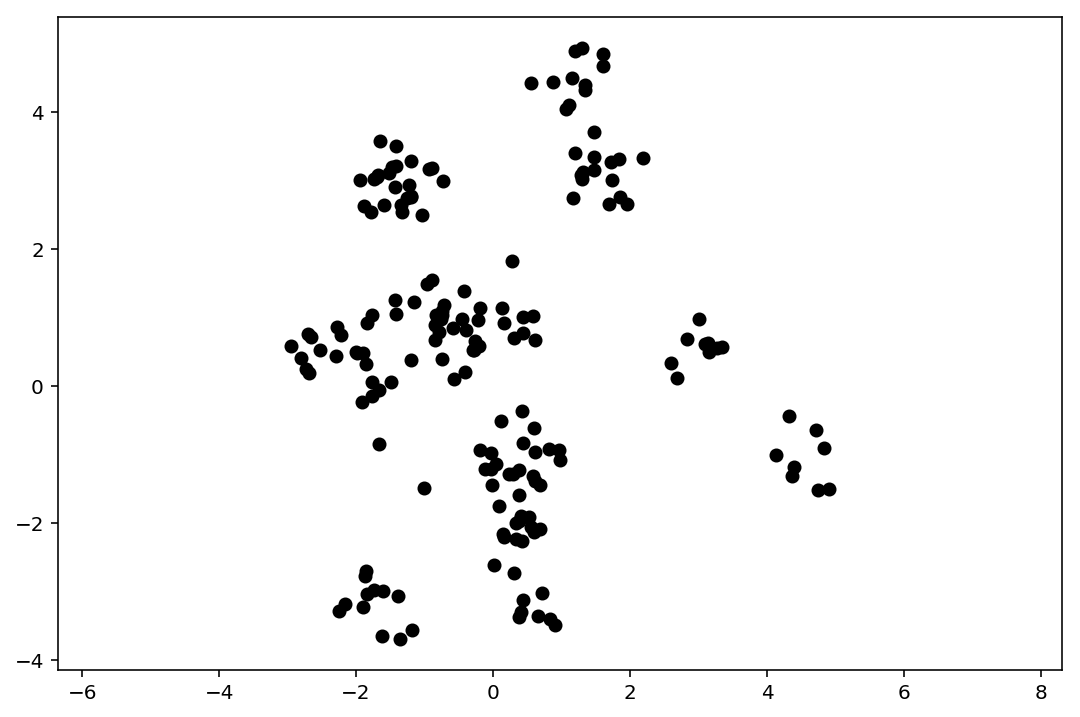

In [315]:
extended_samples = sample(1, Cs = 16, sort_pca = True, params = extended_params)
scatter_xs(extended_samples[-3])

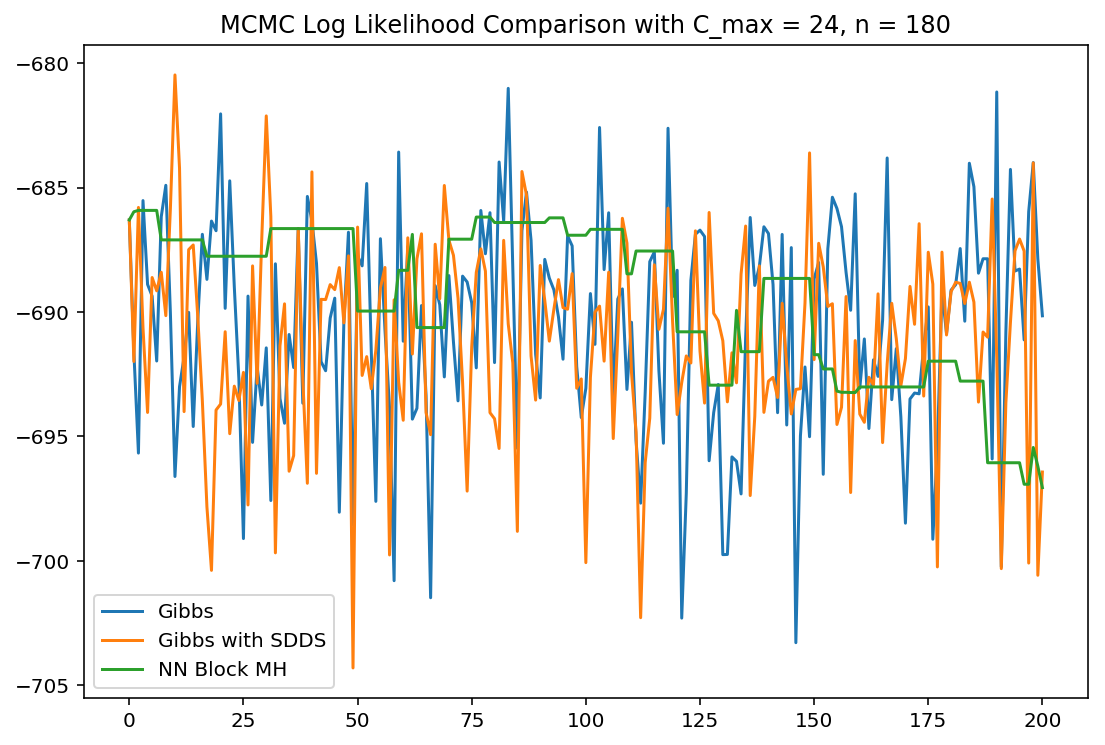

In [316]:
# ground truth initialization
compare_mcmc(
    extended_samples[-3], 
    init_fn = lambda _: extended_samples, 
    burn_in = 200, 
    num_samples = 0,
    params = extended_params
)

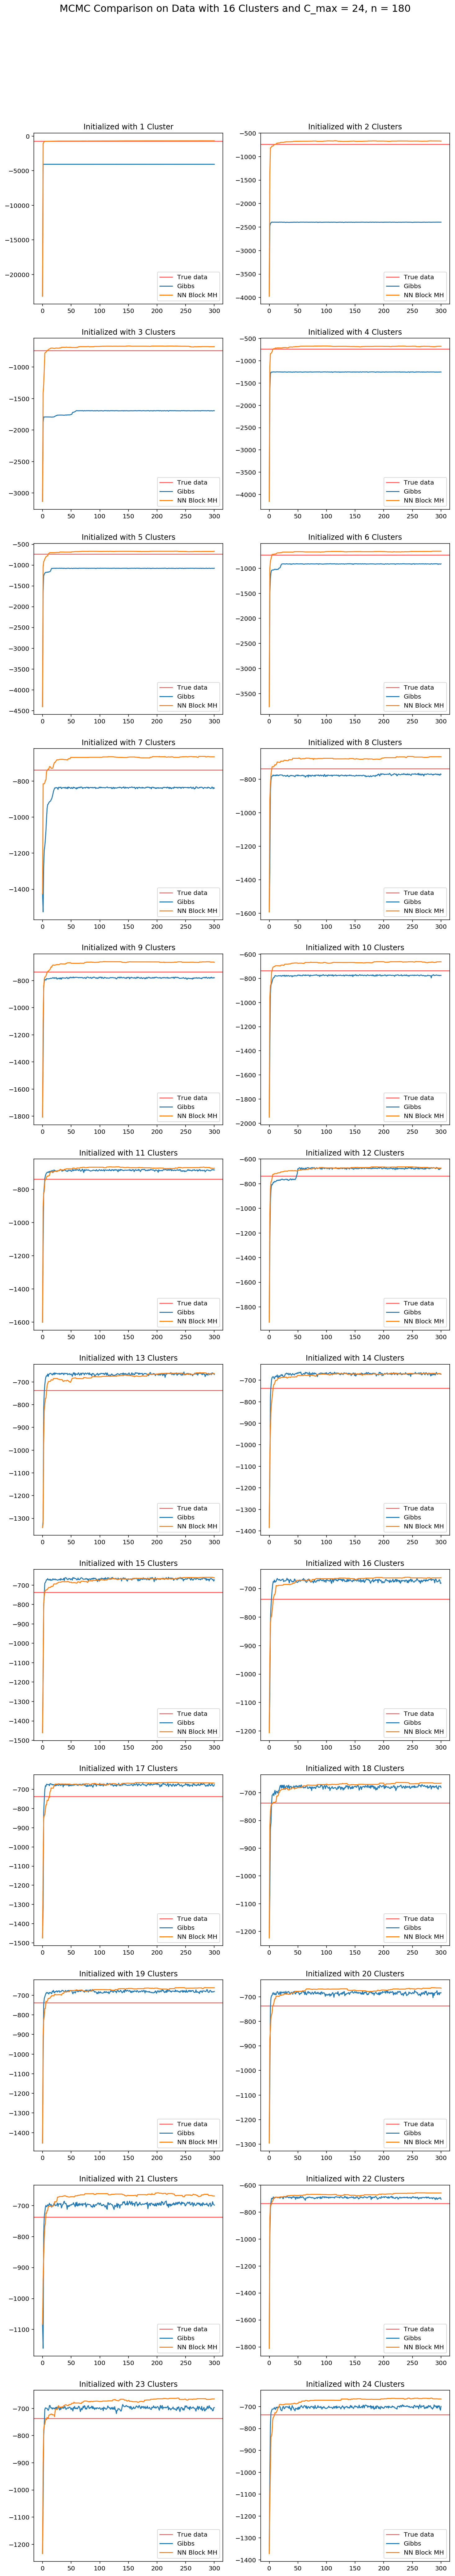

In [176]:
_ = compare_mcmc_different_init_clusters(
    extended_samples,
    burn_in = 300,
    num_samples = 0,
    params = extended_params,
)

In [317]:
K = 100

mcmc_params = dict(
    burn_in = 500, 
    num_samples = 5, 
    sample_int = 20, 
    plotter = None,
    params = extended_params,
)

mcmc_fns = [gibbs, nn_block_mh]

mcmc_sample_colls = [[] for _ in mcmc_fns]

for mcmc_fn, mcmc_samples in zip(mcmc_fns, mcmc_sample_colls):
    print("Running {}...".format(mcmc_fn.__name__))
    for k in range(K):
        print("\r{}/{}".format(k, K), end = "")
        mcmc_samples.append(mcmc_fn(extended_samples[-3], **mcmc_params))
    print("\r\033[Kdone!")

Running gibbs...
done!
Running nn_block_mh...
done!


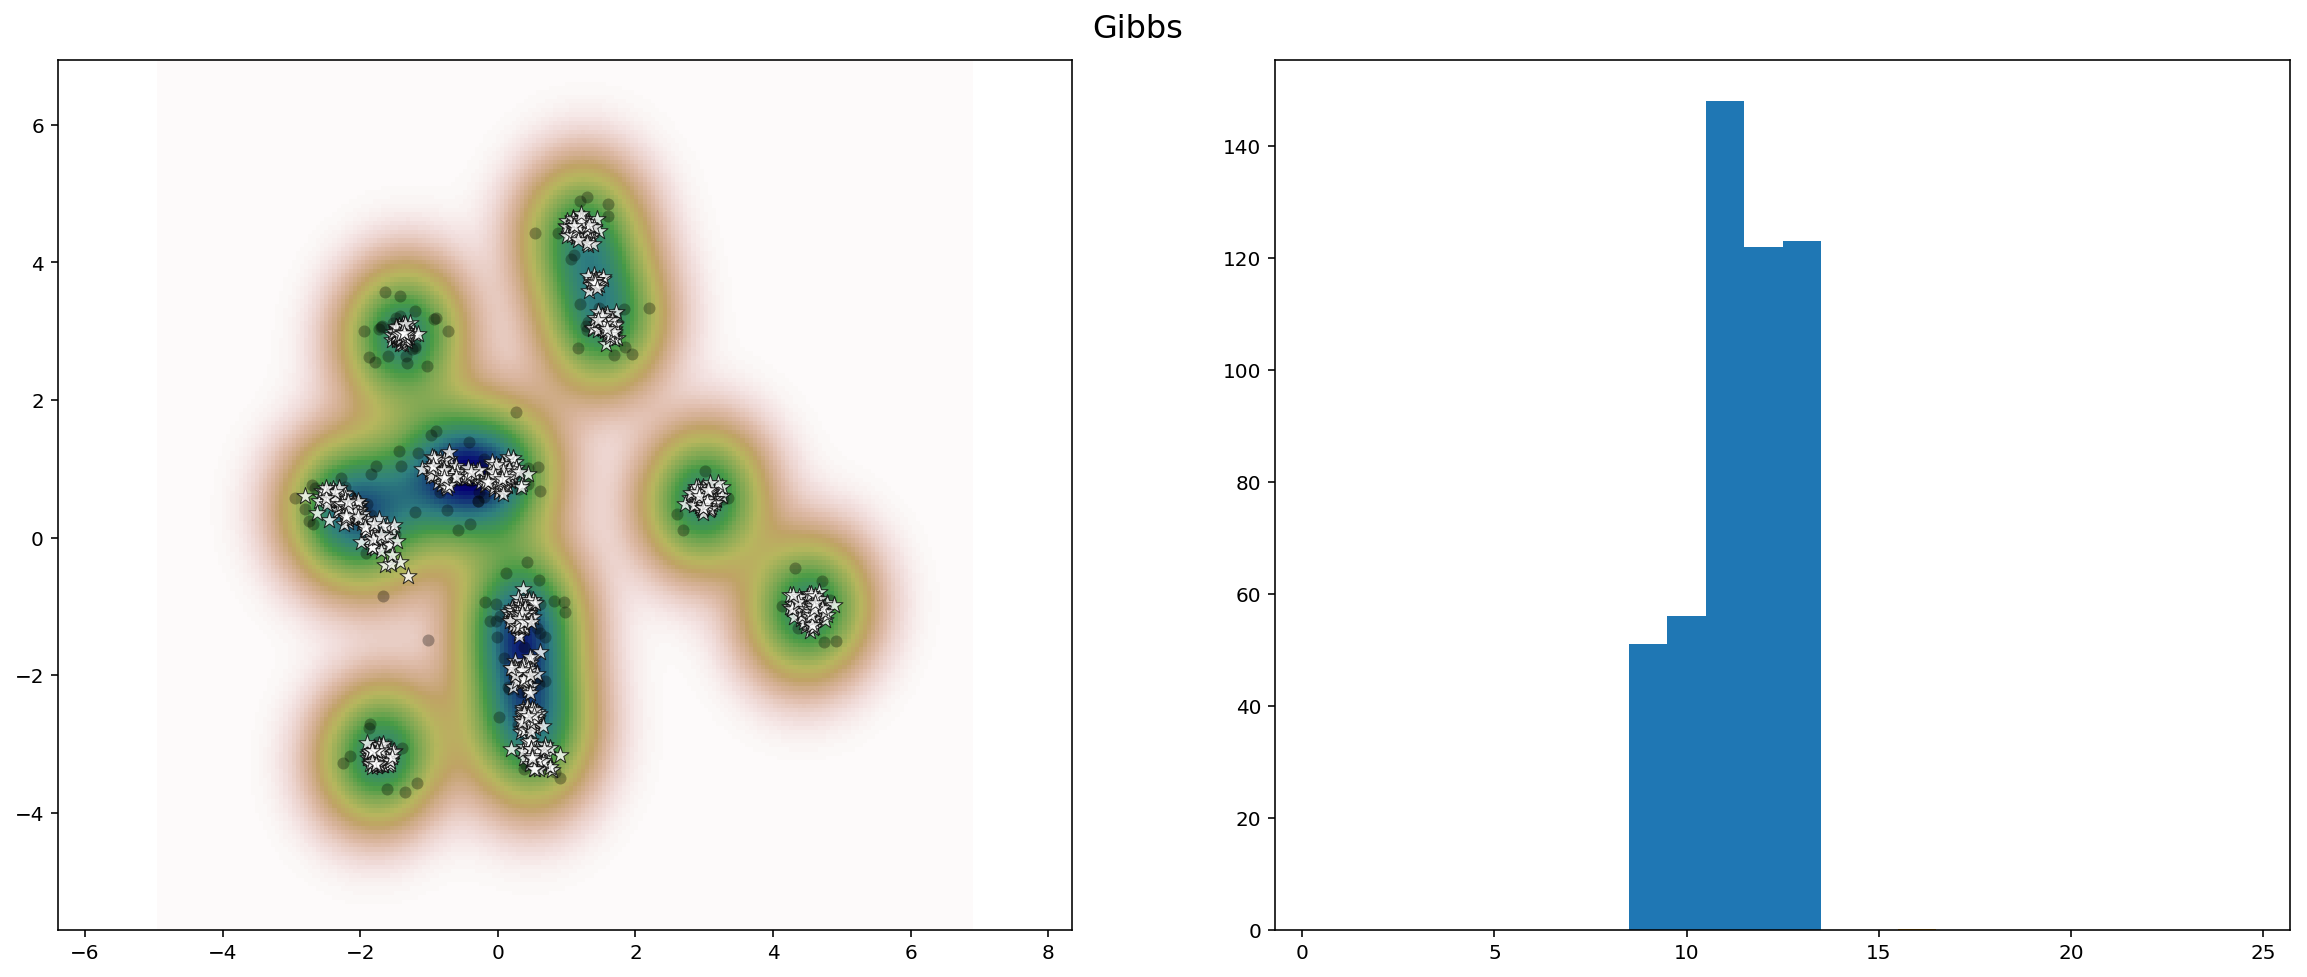

In [320]:
fig, axs = plt.subplots(1, 2, figsize= (20, 8))
fig.suptitle("Gibbs", fontsize = 16, y = 0.92)
sample_mus_kde(extended_samples[-3], mcmc_sample_colls[0], gaussian_bw = 0.3, delta = 200j, ax = axs[0])
sample_Cs_hist(extended_samples[0], mcmc_sample_colls[0], ax = axs[1], params = extended_params)
plt.show()

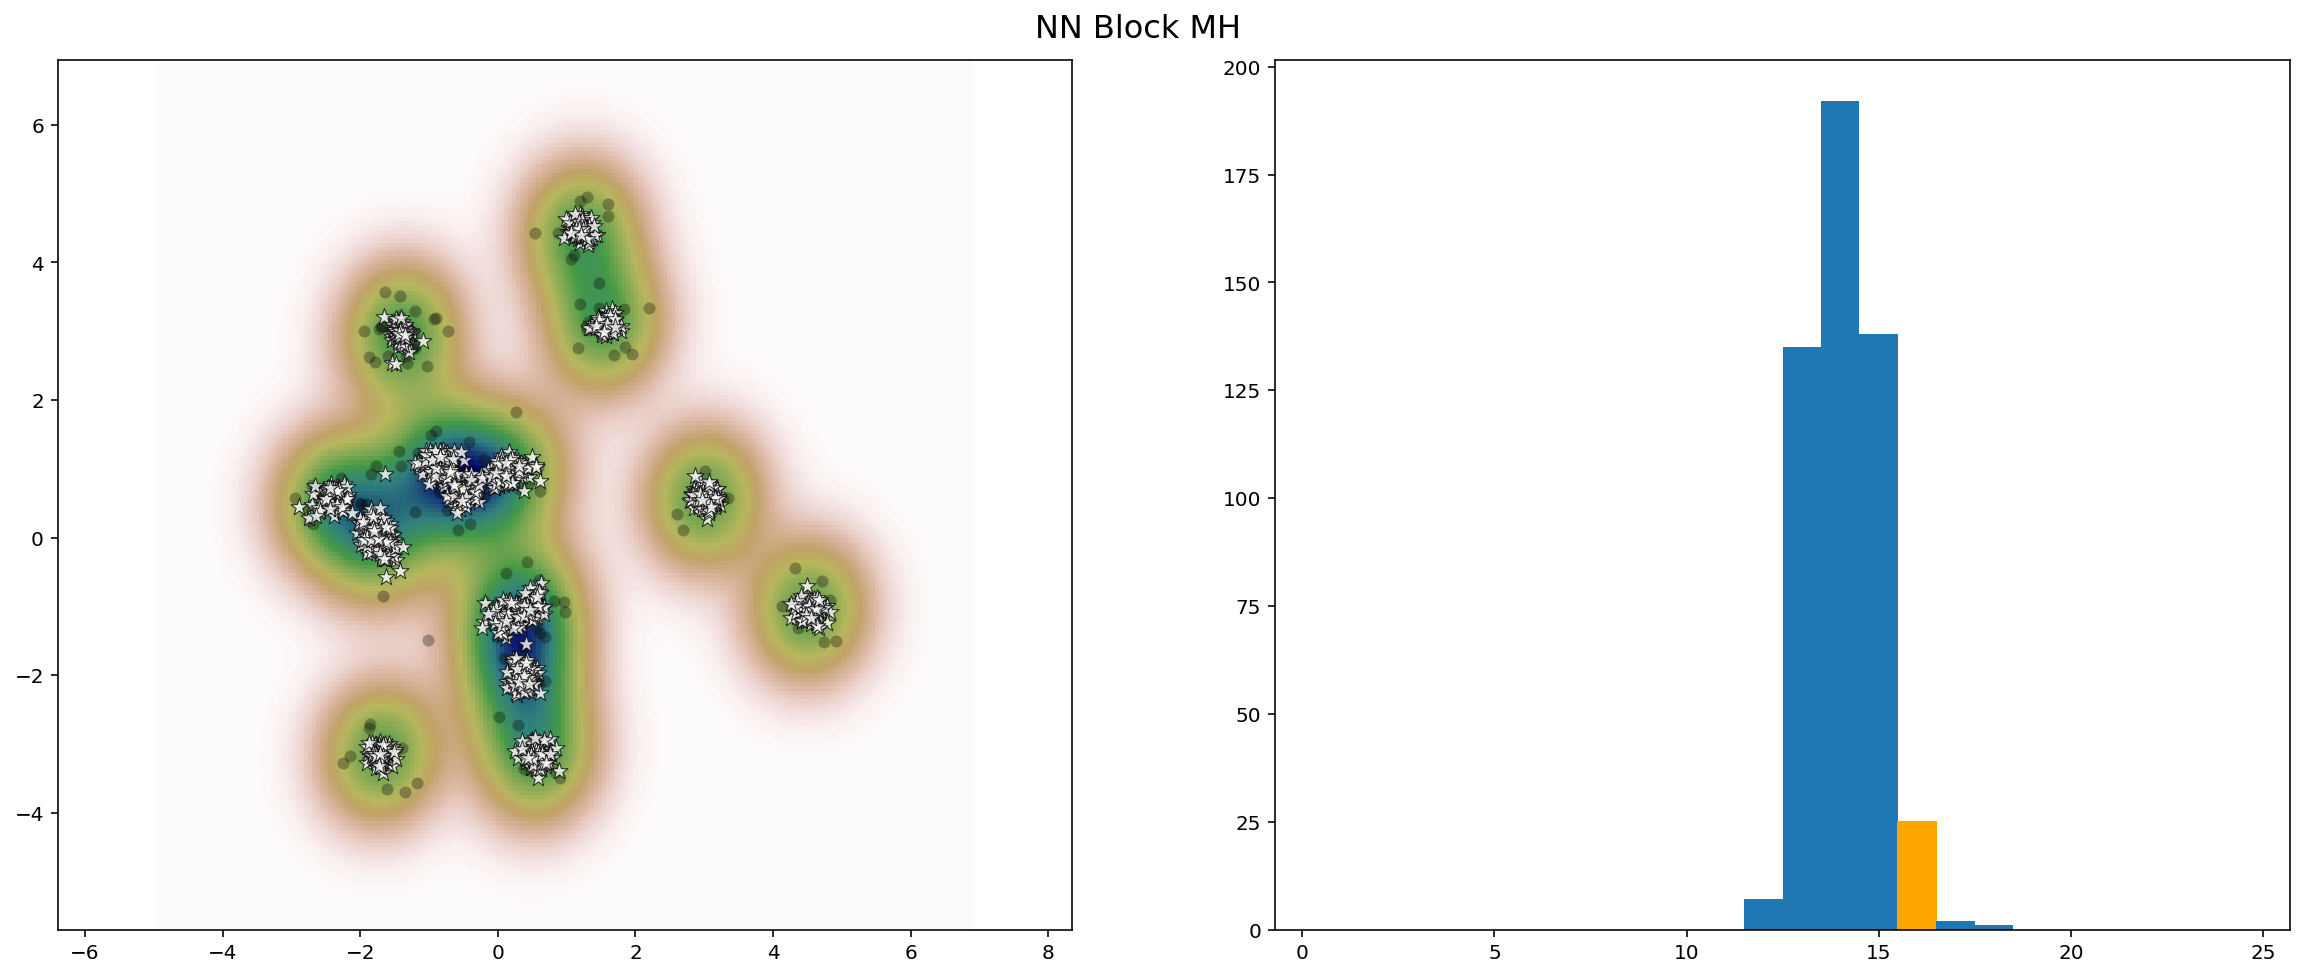

In [321]:
fig, axs = plt.subplots(1, 2, figsize= (20, 8))
fig.suptitle("NN Block MH", fontsize = 16, y = 0.92)
sample_mus_kde(extended_samples[-3], mcmc_sample_colls[1], gaussian_bw = 0.3, delta = 200j, ax = axs[0])
sample_Cs_hist(extended_samples[0], mcmc_sample_colls[1], ax = axs[1], params = extended_params)
plt.show()